In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, HuberRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [133]:
# Перемешаем строки между собой, чтобы они не были упорядочены по датам
df = pd.read_csv("Финальные данные.csv")
df = df.drop_duplicates().reset_index(drop = True)
df= df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,Марка и модель,Выигрышная ставка,Записей о продаже,VIN,Пробег,Дата аукциона,Двигатель,Кузов,Цвет,Топливо,...,Состояние,Стоимость ремонта,Рыночная стоимость,Документы,Тип повреждения,Основное повреждение,Второстепенное повреждение,Коробка передач,Город,Штат
0,2023 Gmc Sierra K2500 At4,$ 22 000 USD,1,1GT49PEY6PF106183,43 096 mi(подтвержден),15.05.2024 17:00 UTC,6.6l 8,NaN,Синий,Дизель,...,улучшенные транспортные средства,$ 52 403 USD,$ 67 000 USD,LA - CERT OF TITLE-SALVAGE,Столкновение,Повреждение передней части,Повреждение стороны,Автоматическая,NEW ORLEANS,LOUISIANA
1,2015 Dodge Charger R/t,$ 4 300 USD,1,2C3CDXCT4FH759663,174 699 mi(подтвержден),16.05.2024 17:00 UTC,5.7l 8,NaN,Белый,Бензин,...,заводится и едет,$ 12 128 USD,$ 15 775 USD,AL - CERT OF TITLE-SALVAGE TITLE,Столкновение,Повсюду,NaN,Автоматическая,MONTGOMERY,ALABAMA
2,2014 Ford Mustang,$ 1 250 USD,2,1ZVBP8EM9E5205516,NaN,17.05.2024 14:00 UTC,3.7l 6,кабриолет,Черный,Бензин,...,улучшенные транспортные средства,$ 12 732 USD,$ 8 550 USD,SC - CERT OF TITLE-SALVAGE,Столкновение,Повреждение передней части,NaN,Автоматическая,GASTON,SOUTH CAROLINA
3,1991 Gmc Sonoma,$ 725 USD,1,1GTCS19Z0M8527266,96 890 mi,14.05.2024 17:00 UTC,4.3l 6,NaN,Темно-бордовый,Бензин,...,заводится и едет,$ 3 427 USD,$ 0 USD,AL - CERT OF TITLE-SALVAGE TITLE,Столкновение,Повреждение передней части,NaN,Автоматическая,HUEYTOWN,ALABAMA
4,2017 Kia Rio Lx,$ 1 000 USD,2,KNADM4A37H6115884,117 955 mi(подтвержден),17.05.2024 17:00 UTC,1.6l 4,4-дверный седан,Черный,Бензин,...,заводится и едет,$ 0 USD,$ 9 525 USD,OK - CERTIFICATE OF TITLE,Дилерские услуги Copart,Повреждение задней части,Повреждение передней части,Автоматическая,TULSA,OKLAHOMA


In [3]:
print(df.columns)

Index(['Марка и модель', 'Выигрышная ставка', 'Записей о продаже', 'VIN',
       'Пробег', 'Дата аукциона', 'Двигатель', 'Кузов', 'Цвет', 'Топливо',
       'Привод', 'Ключи', 'Состояние', 'Стоимость ремонта',
       'Рыночная стоимость', 'Документы', 'Тип повреждения',
       'Основное повреждение', 'Второстепенное повреждение', 'Коробка передач',
       'Город', 'Штат'],
      dtype='object')


In [4]:
df.shape

(3320, 22)

# Предварительныя обработка

**Описание переменных:** 
* `Марка и модель` - год производства, марка, модель автомобиля
* `Записей о продаже` —	количество попыток продажи ($2$ - первая продажа неудачная, вторая - удачная)
* `VIN` - индивидуальный шифр транспортного средства
* `Пробег` - пройденное автомобилем расстояние за весь период использования (в милях) + подтвержден ли пробег специалистами Copart
* `Дата аукциона` - дата продажи автомобиля
* `Двигатель` - переменная вида "{Литры}L {Цилиндры}" - характеристики двигателя
* `Цвет` - цвет автомобиля
* `Коробка передач` - вид коробки передач (механическая или автоматическая)
* `Топливо` - вид используемого топлива
* `Привод` - вид привода (полный, передний, задний, 4x4)
* `Состояние` - категорильная переменная, которая объединяет в себя 
    - наличие чистки 
    - возможность машины ехать 
    - запуск двигателя
* `Город` - город продажи автомобиля
* `Штат` - штат продажи автомобиля
* `Стоимость ремонта` - стоимость проведенного для восстановления после повреждения машины ремонта
* `Рыночная стоимость` - оценочная розничная стоимость - Это примерная рыночная стоимость лота по оценке продавца, который продал транспортное средство Copart
* `Документы` - (тип права собственности/тип техпаспорта) — это документы на право владения, которые будут переданы участнику
* `Тип повреждения` - что привело к повреждению -> продаже на аукционе
* `Основное повреждение` - вид главного повреждения
* `Второстепенное повреждение` - вид второго повреждения (NaN - если его нет)
* `Ключи` - указывает, имеются ли у компании Copart ключи от автомобиля
* `Кузов` - вид кузова (NaN - если его нет)

**Целевая переменная:** `Выигрышная ставка` — цена продажи на аукционе (в долларах)

Ссылка на доп объяснение: https://www.copart.com/ru/Content/us/ru/Support/FAQ-Topics/Common-Terms

## Приведение данных в единый вид и формирование новых признаков

__Перевод на английский язык:__ Так как часть данных представлена на русском, часть - на английском языке, было решено перевести данные на английский с использованием терминов оригинального аукциона - Copart. С помощью перевода в истинные термины также были устранены проблемы с некорректным переводом сайта, с которого парсили данные.

In [134]:
def engine(x:str) -> float:
    """
    Функция для формирования признака "Литры"
    :param x: str - значение признака "Двигатель"
    :return: число -- значения литров
    """
    if pd.isna(x):
        return x
    elif 'L' not in x and 'l' not in x:
        return np.NaN
    elif 'L' in x:
        return float(x.split()[0])
    elif 'l' in x:
        return float(x.split()[0][:-1])
    else:
        return x
    
def color(x:str) -> str:
    """
    Функция для перевода в английский признака "Цвет"
    :param x: str - значение признака "Цвет"
    :return: str
    """
    if x == 'Черный':
        return 'Black'
    elif x == 'Серебряный':
        return 'Silver'
    elif x == 'Белый':
        return 'White'
    elif x == 'Угольный':
        return 'Charcoal'
    elif x == 'Синий':
        return 'Blue'
    elif x == 'Золотой':
        return 'Gold'
    elif x == 'Серый':
        return 'Grey'
    elif x == 'Зеленый':
        return 'Green'
    elif x == 'Желтый':
        return 'Yellow'
    elif x == 'Темно-бордовый':
        return 'Maroon'
    elif x == 'Красный':
        return 'Red'
    elif x == 'Бордовый':
        return 'Burgundy'
    elif x == 'Коричневый':
        return 'Brown'
    elif x == 'Желто-коричневый':
        return 'Yellow-brown'
    elif x == 'Бежевый':
        return 'Beige'
    elif x == 'Оранжевый':
        return 'Orange'
    elif x == 'Бирюзовый':
        return 'Turquoise'
    elif x == 'Двухцветный':
        return 'Two-color'
    elif x == 'Фиолетовый':
        return 'Purple'
    elif x == 'Розовый':
        return 'Pink'
    elif x == 'Кремовый':
        return 'Cream'
    else:
        return x   
    
def transmission(x:str) -> str:
    """
    Функция для перевода в английский признака "Коробка передач"
    :param x: str - значение признака "Коробка передач"
    :return: str
    """
    if x == 'Автоматическая':
        return 'Automatic'
    elif x == 'Механическая':
        return 'Manual'
    else:
        return x
    
def fuel(x:str) -> str:
    """
    Функция для перевода в английский признака "Топливо"
    :param x: str - значение признака "Топливо"
    :return: str
    """
    if x == 'Бензин':
        return 'Flexible Fuel' #Petrol
    elif x == 'Этанолосодержащий бензин':
        return 'Ethenol Flex Fuel'
    elif x == 'Гибрид':
        return 'Hybrid'
    elif x == 'Дизель':
        return 'Diesel'
    elif x == 'Электричество':
        return 'Electric'
    elif x == 'Сжатый природный газ':
        return 'Compressed Natural Gas'
    else:
        return x
    
def Drive_Train(x:str) -> str:
    """
    Функция для перевода в английский признака "Привод"
    :param x: str - значение признака "Привод"
    :return: str
    """
    if pd.isna(x):
        return x
    else:
        x = x.lower()
        if x == 'передний привод':
            return 'Front-wheel Drive'
        elif x == 'задний привод':
            return 'Rear-wheel Drive'
        elif x == 'полный привод':
            return 'All Wheel Drive'
        elif x == '4х4 с передним приводом':
            return '4x4 w/front Whl Drv'
        elif x == '4х4 с задним приводом':
            return '4x4 w/rear Whl Drv'
        elif x == '4x4':
            return 'Four by Four'
        else:
            return x
        
def vehicle_condition_type(x:str) -> str:
    """
    Функция для перевода в английский признака "Основное повреждение"
    :param x: str - значение признака "Основное повреждение"
    :return: str
    """
    if x == 'Повреждение передней части':
        return 'Front End'
    elif x == 'Повреждение стороны':
        return 'Side'
    elif x == 'Повреждение задней части':
        return 'Rear End'
    elif x == 'Повсюду':
        return 'All Over'
    elif x == 'Вода/Наводнение':
        return 'Water/Flood'
    elif x == 'Незначительная вмятина/царапины':
        return 'Minor Dents/Scratches'
    elif x == 'Вандализм':
        return 'Vandalism'
    elif x == 'Повреждение ходовой части':
        return 'Undercarriage'
    elif x == 'Град':
        return 'Hail'
    elif x == 'Механическое повреждение': 
        return 'Mechanical'
    elif x == 'Повреждение рамы':
        return 'Frame Damage Reported'
    elif x == 'Опрокидывание/Перевертышь': 
        return 'Rollover'
    elif x == 'Нормальный износ':
        return 'Normal Wear'
    elif x == 'Пожар':
        return 'Burn'
    elif x == 'Верх/крыша':
        return 'Top/Roof'
    elif x == 'Пожар двигателя':
        return 'Burn - Engine'
    elif x == 'Пожар в салоне':
        return 'Burn - Cabin'
    elif x == 'Отсутствует/Изменен VIN':
        return 'Missing/Altered VIN'
    elif x == 'Биологическая/Химическая опасность':
        return 'Biohazardous/Chemical'
    elif x == 'Частичный ремонт':
        return 'Partial/Incomplete Repair'
    elif x == 'История повреждений':
        return 'Damage History'
    elif x == 'Отказ в ремонте':
        return 'Rejected Repair'
    elif x == 'Разукомплектовано':
        return 'Stripped'
    elif x == 'Неизвестно':
        return 'Unknown'
    else:
        return x
    
body_style = {
    '4-дверный седан': 'Sedan 4d',
    'хэтчбек': 'Hatchbac',
    '4-дверный спорт': '4dr Spor',
    'кабриолет':'Converti',
    'спортивная версия': 'Sports V',
    '4-дверный удлиненный': '4dr Ext',
    'пожарная машина': 'Fire Tru',
    'пикап экипажа':  'Crew Cha',
    'клубное такси': 'Club Cap',
    'купе': 'Coupe',
    'подбирать': 'Pickup',
    '2 двери спорт': '2dr Spor',
    '3-х дверное купе': 'Coupe 3d', 
    'грузовой фургон': 'Cargo Va',
    'обычная кабина': 'Tilt Cab', 
    'стационарный (неподвижный)': 'Station', 
    'расширенный': 'Extended',
    '3-дверный удлиненный': '3dr Ext', 
    'шасси': 'Chassis', 
    'спортивный пикап': 'Sports Pi',
    'трактор': 'Tractor',
    'моторизованный': 'Motorized',
    'наклонная кабина': 'Kneeling', 
    '2 двери в разрезе': '2dr Cut', 
    'родстер': 'Roadster',
    'гонщик': 'Racer',
    '2-дверный седан': 'Sedan 2d', 
    'экипаж': 'Crew', 
    'неполный': 'Incomplete'

}

vehicle_conition = {
    'улучшенные транспортные средства': 'Enhanced Transport',
    'заводится и едет': 'Run and Drive',
    'двигатель запускается': 'Engine Start Program'
}

damage_type = {
    'Столкновение': 'Collision',
    'Неизвестно': 'Unknown',
    'Кража': 'Theft',
    'Вода/Наводнение': 'Water/Flood',
    'Вандализм': 'Vandalism',
    'Град': 'Hail',
    'Дилерские услуги Copart': 'Dealer Services',
    'Аренда': 'Rent',
    'Материальный ущерб': 'Material damage', 
    'Изьятие': 'Seizure',
    'Конфискат': 'Confiscation',
    'Пожертвование': 'Donation',
    'Диллерский коносамент': 'Dealer Bill of Lading',
    'Публичный коносамент': 'Public bill of lading',
    'Пожар': 'Fire',
    'Ураган': 'Hurricane',
    'Незастрахованное авто': 'Uninsured car', 
    'Катастрофа': 'Catastrophe'
}

def convert_to_weekdays(date_str):
    try:
        date = pd.to_datetime(date_str)
        if 13 <= date.day <= 17:
            if date.day == 13:
                return "Понедельник"
            elif date.day == 14:
                return "Вторник"
            elif date.day == 15:
                return "Среда"
            elif date.day == 16:
                return "Четверг"
            elif date.day == 17:
                return "Пятница"
        else:
            return None
    except ValueError:
        return 'Неверный формат даты'
    
def convert_to_time_categories(time_str):
    try:
        time = pd.to_datetime(time_str)
        hour = time.hour
        
        if 6 <= hour < 17:
            return "День"
        elif 17 <= hour < 23:
            return "Вечер"
    except ValueError:
        return "Неверный формат времени"
    
def extract_year_and_make(row):
    parts = row.split(" ")
    year, make = parts[0], parts[1]
    return pd.Series([year, make])

In [135]:
#перевод в числа, избавление от знака долларов
df['Выигрышная ставка'] = df['Выигрышная ставка'].apply(lambda x: int(''.join(x.split()[1:-1])))

#Формирование новой переменной из исходной переменной 'Пробег' - "Подтвержденность пробега"
df['Подтвержденность пробега'] = df['Пробег'].apply(lambda x: 1 if 'подтвержден' in str(x) else 0)

#Удаление данные о подтвержденности пробега из исходной переменной 'Пробег' и перевод в числа
df['Пробег'] = df['Пробег'].apply(lambda x: float(''.join(str(x).split()[:-1])) if not pd.isna(x) else np.NaN)

#перевод в тип datetime
df['Дата аукциона'] = pd.to_datetime(df['Дата аукциона'], dayfirst=True)

#Формирование новой переменной из исходной переменной 'Двигатель'. Исходная переменная имеет вид '{Литры}L {Цилиндры}'
#В качестве новой переменной использовались данные из переменной 'Двигатель' о цилиндрах + перевод в числа
df['Цилиндры'] = df['Двигатель'].apply(lambda x: x.split()[-1] if not pd.isna(x) else x)

#В качестве новой переменной использовались данные из переменной 'Двигатель' о литрах + перевод в числа
df['Литры'] = df['Двигатель'].apply(engine)

#удаление объектов без нужных данных о литрах и цилиндрах
df = df.drop(df[df['Цилиндры'] == 'U'].index, axis = 0)
df = df.drop(df[df['Цилиндры'] == 'R'].index, axis = 0)

#удаление исходной переменной
df = df.drop('Двигатель', axis = 1)

# Разделение столбца "Марк и модель" на два столбца — "Year" и "Brand"
df[['Год', 'Марка']] = df['Марка и модель'].apply(extract_year_and_make)
df['Год'] = df['Год'].astype(int)
df.drop(columns=['Марка и модель'], inplace=True)

# Разделение столбца "Дата аукциона" на два столбца — "Дата аукциона" и "Время продажи"
df['Дата аукциона'] = df['Дата аукциона'].astype(str)
df[['Дата аукциона', 'Время продажи']] = df['Дата аукциона'].str.split(" ", expand=True)


In [136]:
#удаление объектов без указанного пробега
df = df.dropna(subset = ['Пробег'])
df = df.reset_index(drop = True)

In [137]:
#перевод цвета на английский язык - приведение в унифицированный вид
df['Цвет'] = df['Цвет'].apply(color)

#Возврат терминов к исходным - тем, которые используются на Copart
df['Коробка передач'] = df['Коробка передач'].apply(transmission)
df['Топливо'] = df['Топливо'].apply(fuel)
df['Привод'] = df['Привод'].apply(Drive_Train)

#перевод в числа, избавление от знака долларов
df['Стоимость ремонта'] = df['Стоимость ремонта'].apply(lambda x: int(''.join(x.split()[1:-1])))
df['Рыночная стоимость'] = df['Рыночная стоимость'].apply(lambda x: int(''.join(x.split()[1:-1])))

#Возврат терминов к исходным - тем, которые используются на Copart
df['Основное повреждение'] = df['Основное повреждение'].apply(vehicle_condition_type)
df['Второстепенное повреждение'] = df['Второстепенное повреждение'].apply(lambda x: 'No' if pd.isna(x) else vehicle_condition_type(x))
df['Тип повреждения'] = df['Тип повреждения'].apply(lambda x:x if pd.isna(x) else damage_type[x])

#Формирование бинарной переменной из исходной
df['Ключи'] = df['Ключи'].apply(lambda x: 0 if pd.isna(x) else 1) #Если есть - 1

#Замена NaN на категорию, означающую отсутсвие кузова + возврат терминов к исходным - тем, которые используются на Copart
df['Кузов'] = df['Кузов'].apply(lambda x:  'No' if pd.isna(x) else  body_style[x])

df['Состояние'] = df['Состояние'].apply(lambda x: x if pd.isna(x) else vehicle_conition[x])

#Формирование новых переменных из исходной переменной "Состояние" - переменная о наличии чистки (бинарная)
df['Чистка'] = df['Состояние'].apply(lambda x: 1 if x == 'Enhanced Transport' else 0)
#Формирование новых переменных из исходной переменной "Состояние" - переменная о возможности машины ехать (бинарная)
df['Едет'] = df['Состояние'].apply(lambda x: 1 if x == 'Run and Drive' else 0)
#Формирование новых переменных из исходной переменной "Состояние" - переменная о возможности запуска двигателя (бинарная)
df['Запуск двигателя'] = df['Состояние'].apply(lambda x: 1 if x == 'Run and Drive' or x == 'Engine Start Program' else 0)
df = df.drop('Состояние', axis = 1).reset_index(drop = True)

df = df.rename(columns={"Документы": "Техпаспорт"})

# Преобразуем дату аукциона в день недели
df['День недели'] = df['Дата аукциона'].apply(convert_to_weekdays)
df = df.dropna(subset=['День недели'])
df = df.drop('Дата аукциона', axis=1)
# Преобразуем время продажи автомобиля в категориальную перменную, показывающую в какой период суток произошла продажа
df['Период суток'] = df['Время продажи'].apply(convert_to_time_categories)
df = df.drop('Время продажи', axis=1)


__Оставшиеся пропуски:__ 
* `Коробка передач` - так как данные не предоставлены, заполнить модой было бы неверно, так как она может также не присутствовать в машине
* `Привод` - категориальная переменная. Модой заполнить пропуски кажется некорректным, так как машина может быть по-разному укомплектована
* `Литры` - переменная представлена в числовом виде, однако двигатели обычно имеют стандартный набор возможных литров (похоже на категориальную). При этом если посмотреть нв отдельные наблюдения с пропусками, там могут быть мотоциклы, литры двигателей которых сильно отличаются от двигателей автомобилей

Поэтому все оставшиеся пропуски удаляются

In [138]:
df = df.dropna(subset=['Коробка передач', 'Привод', 'Литры'])

In [139]:
df.shape

(2718, 28)

In [140]:
df.columns

Index(['Выигрышная ставка', 'Записей о продаже', 'VIN', 'Пробег', 'Кузов',
       'Цвет', 'Топливо', 'Привод', 'Ключи', 'Стоимость ремонта',
       'Рыночная стоимость', 'Техпаспорт', 'Тип повреждения',
       'Основное повреждение', 'Второстепенное повреждение', 'Коробка передач',
       'Город', 'Штат', 'Подтвержденность пробега', 'Цилиндры', 'Литры', 'Год',
       'Марка', 'Чистка', 'Едет', 'Запуск двигателя', 'День недели',
       'Период суток'],
      dtype='object')

In [2026]:
df.head()

,Выигрышная ставка,Записей о продаже,VIN,Пробег,Кузов,Цвет,Топливо,Привод,Ключи,Стоимость ремонта,...,Подтвержденность пробега,Цилиндры,Литры,Год,Марка,Чистка,Едет,Запуск двигателя,День недели,Период суток
0,22000,1,1GT49PEY6PF106183,43096.0,No,Blue,Diesel,4x4 w/rear Whl Drv,1,52403,...,1,8,6.6,2023,Gmc,1,0,0,Среда,Вечер
1,4300,1,2C3CDXCT4FH759663,174699.0,No,White,Flexible Fuel,Rear-wheel Drive,1,12128,...,1,8,5.7,2015,Dodge,0,1,1,Четверг,Вечер
2,725,1,1GTCS19Z0M8527266,96890.0,No,Maroon,Flexible Fuel,Rear-wheel Drive,1,3427,...,0,6,4.3,1991,Gmc,0,1,1,Вторник,Вечер
3,1000,2,KNADM4A37H6115884,117955.0,Sedan 4d,Black,Flexible Fuel,Front-wheel Drive,1,0,...,1,4,1.6,2017,Kia,0,1,1,Пятница,Вечер
5,2750,2,3N1AB8CV3MY315913,18743.0,No,Burgundy,Flexible Fuel,Front-wheel Drive,1,0,...,1,4,2.0,2021,Nissan,0,0,1,Понедельник,Вечер


## Итоговое описание сформированного датасета

**Описание переменных:** 

* `Записей о продаже` —	количество попыток продажи ($2$ - первая продажа неудачная, вторая - удачная)
* `VIN` - индивидуальный шифр транспортного средства
* `Пробег` - пройденное автомобилем расстояние за весь период использования (в милях)
* `Подтвержденность пробега` - подтвержден ли указанный пробег экспертами или нет (бинарная переменная: $1$ - подтвержден)
* `День недели` - день недели продажи автомобиля (понедельник - пятница (аукцион работает по будням)
* `Период суток` - период суток продажи автомобиля(день-вечер)
* `Цвет` - цвет автомобиля
* `Коробка передач` - вид коробки передач (механическая или автоматическая)
* `Топливо` - вид используемого топлива
* `Привод` - вид привода (полный, передний, задний, 4x4)
* `Стоимость ремонта` - стоимость проведенного для восстановления после повреждения машины ремонта
* `Рыночная стоимость` - оценочная розничная стоимость - Это примерная рыночная стоимость лота по оценке продавца, который продал транспортное средство Copart
* `Техпаспорт` - (тип права собственности) — это документы на право владения, которые будут переданы участнику
* `Тип повреждения` - что привело к повреждению -> продаже на аукционе
* `Основное повреждение` - вид главного повреждения
* `Второстепенное повреждение` - вид второго повреждения (Nо - если его нет)
* `Ключи` - указывает, имеются ли у компании Copart ключи от автомобиля
* `Кузов` - вид кузова ($No$ - если его нет)
* `Подтвержденность пробега` - подтвержден ли экспертам Copart пробег автомобиля (бинарная переменная)($1$ - подтвержден)
* `Цилиндры` - характеристика двигателя
* `Литры` - характеристика двигателя
* `Штат` -  штат продажи
* `Город` - город продажи
* `Чистка` - проверили ли эксперты дополнительные работы по приведению автомобиля в товарный вид (мойка, чистка, нанесение защитного покрытия...). Бинарная переменная ($1$ - чистка проведена)
* `Едет` - переменная показывает, может ли машина ехать. Бинарная переменная ($1$ - машина может ехать)
* `Запуск двигателя` - запускается ли двигатель. Бинарная переменная ($1$ - двигатель запускается)
* `Год` —	год производства
* `Марка` —	марка авттомобиля

**Целевая переменная:** `Выигрышная ставка` — цена продажи на аукционе (в долларах)

# Визуализация

In [16]:
df = df.set_index('VIN')

In [26]:
var_cat = np.array(['Марка', 'День недели', 'Период суток', 'Цвет', 'Коробка передач', 'Топливо', 'Привод', 'Техпаспорт', 'Тип повреждения', 'Основное повреждение', 
           'Второстепенное повреждение', 'Ключи', 'Кузов', 'Подтвержденность пробега', 'Цилиндры', 'Штат', 'Город', 'Чистка', 
          'Едет', 'Запуск двигателя', 'Записей о продаже'])

var_real = np.array(['Год', 'Литры', 'Пробег', 'Стоимость ремонта', 'Рыночная стоимость', 'День недели', 'Период суток'])

target = 'Выигрышная ставка'

## Распределение целевой переменной

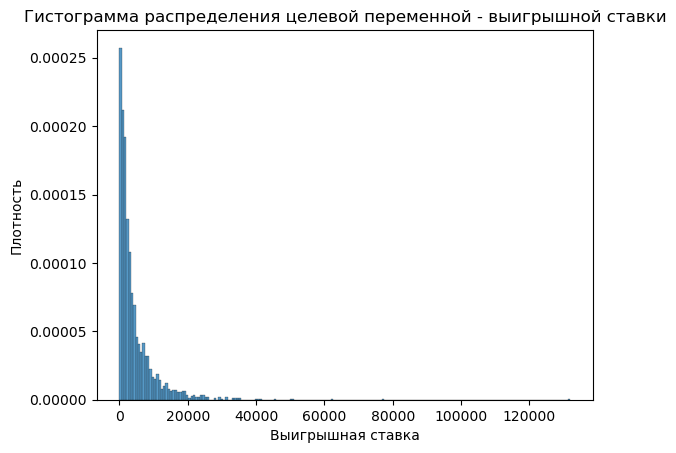

In [18]:
sns.histplot(df[target], stat = 'density')
plt.title('Гистограмма распределения целевой переменной - выигрышной ставки')
plt.ylabel('Плотность');

__Небольшой вывод:__ Заметно, что в данных очень много выбросов, поэтому нужно посмотреть на сглаженные данные (возьмем логарифм целевой переменной)

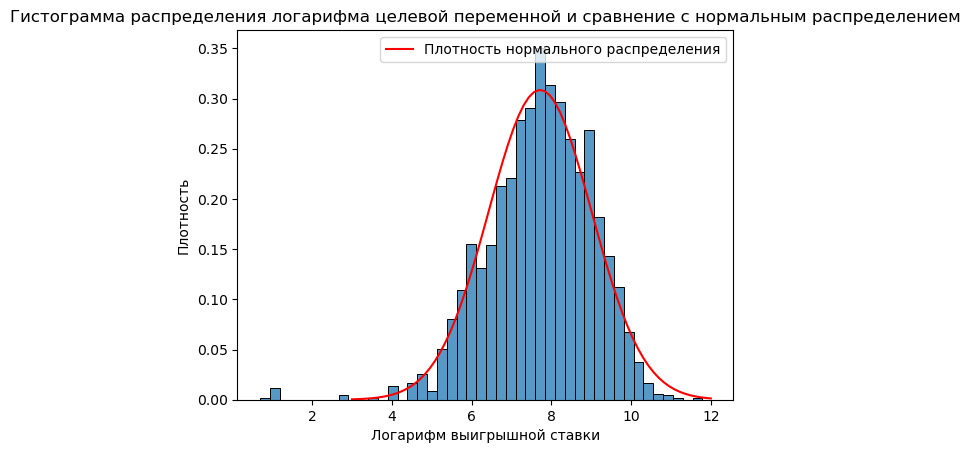

In [19]:
mean = df[target].apply(lambda x: np.log(1 + x)).mean()
std = df[target].apply(lambda x: np.log(1 + x)).std()
t = np.linspace(3, 12, 70)
y = stats.norm(loc = mean, scale = std).pdf(t)
sns.lineplot(x = t, y = y, label = 'Плотность нормального распределения', color = 'red')
sns.histplot(df[target].apply(lambda x: np.log(1 + x)), stat = 'density')
plt.legend()
plt.title('Гистограмма распределения логарифма целевой переменной и сравнение с нормальным распределением')
plt.xlabel('Логарифм выигрышной ставки')
plt.ylabel('Плотность');

__Небольшой вывод:__ Распределение переменной - логарифм выигрышной ставки - сильно похоже на нормальное распределение. Хвосты маленькие, выбросов нет.

## Непрерывные переменные

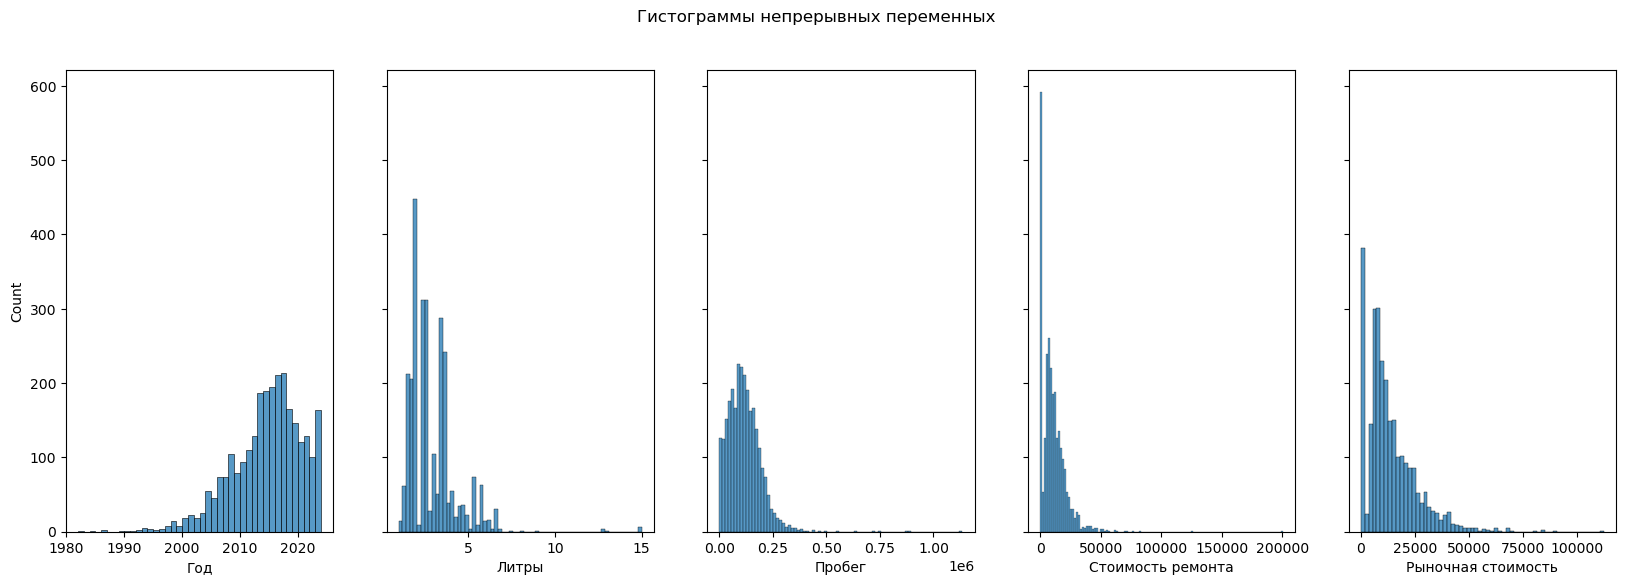

In [20]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(20, 6))
fig.suptitle('Гистограммы непрерывных переменных')
for i in range(0, 5):
    sns.histplot(df[var_real[i]], ax = axs[i])

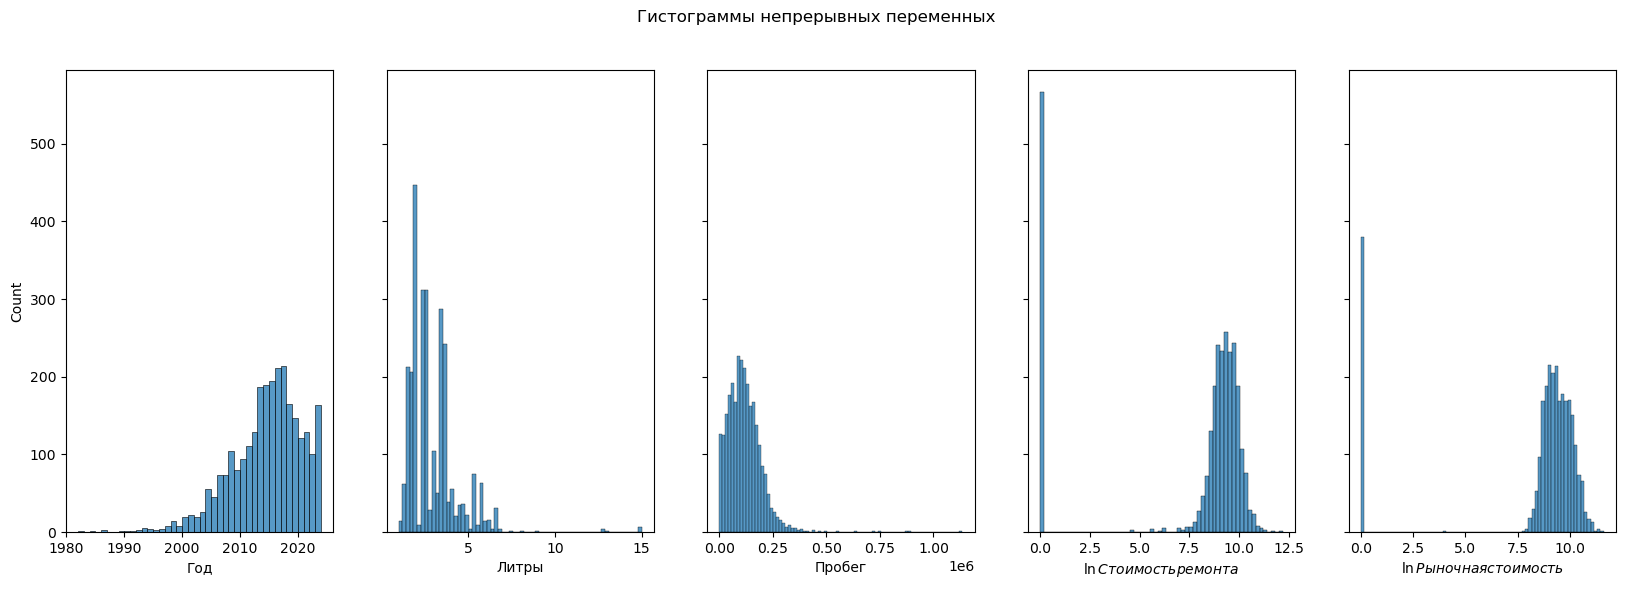

In [21]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(20, 6))
fig.suptitle('Гистограммы непрерывных переменных')
for i in range(0, 3):
    sns.histplot(df[var_real[i]], ax = axs[i])
for i in range(3, 5):
    sns.histplot(df[var_real[i]].apply(lambda x: np.log(1 + x)), ax = axs[i])
    axs[i].set_xlabel(f'$ \ln{var_real[i]}$')

## Корреляция вещественных переменных с таргетом

In [2033]:
df['Логарифм таргета'] = df[target].apply(lambda x: np.log(1 + x))

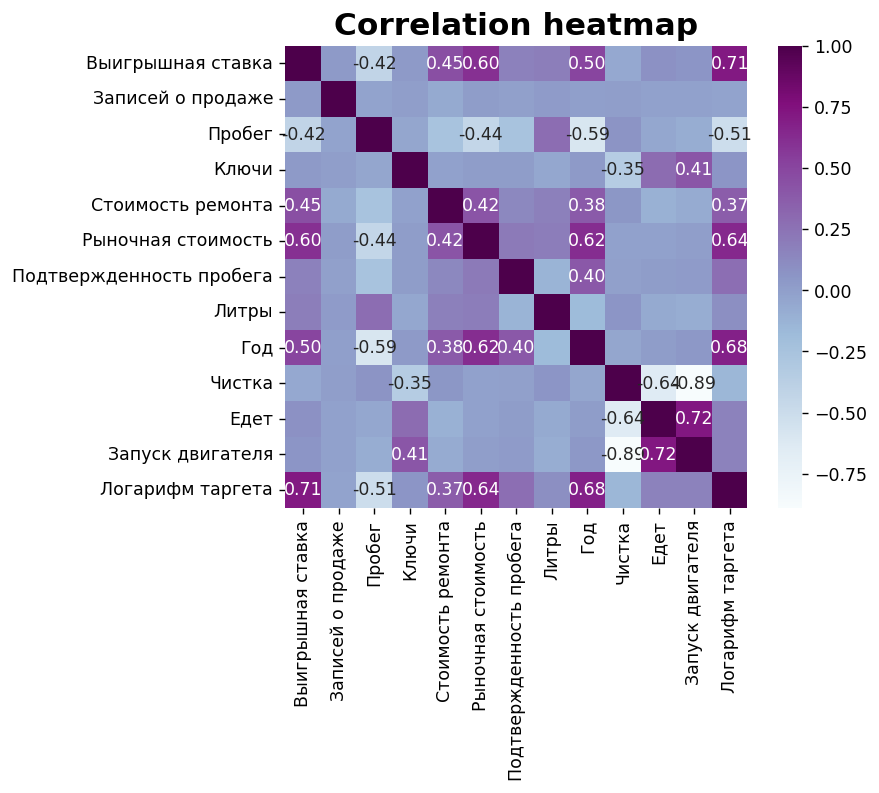

In [2034]:
plt.figure(dpi=125)
ax = sns.heatmap(df.corr(numeric_only= True), cmap="BuPu", annot=True, fmt="0.2f", square = True)
plt.title('Correlation heatmap', fontsize=18, fontweight="bold")
for t in ax.texts:
    if (float(t.get_text()) >= 0.3 or float(t.get_text()) <= -0.3) and t.get_position()[0] != t.get_position()[1]:
        t.set_text(t.get_text())
    else:
        t.set_text("")

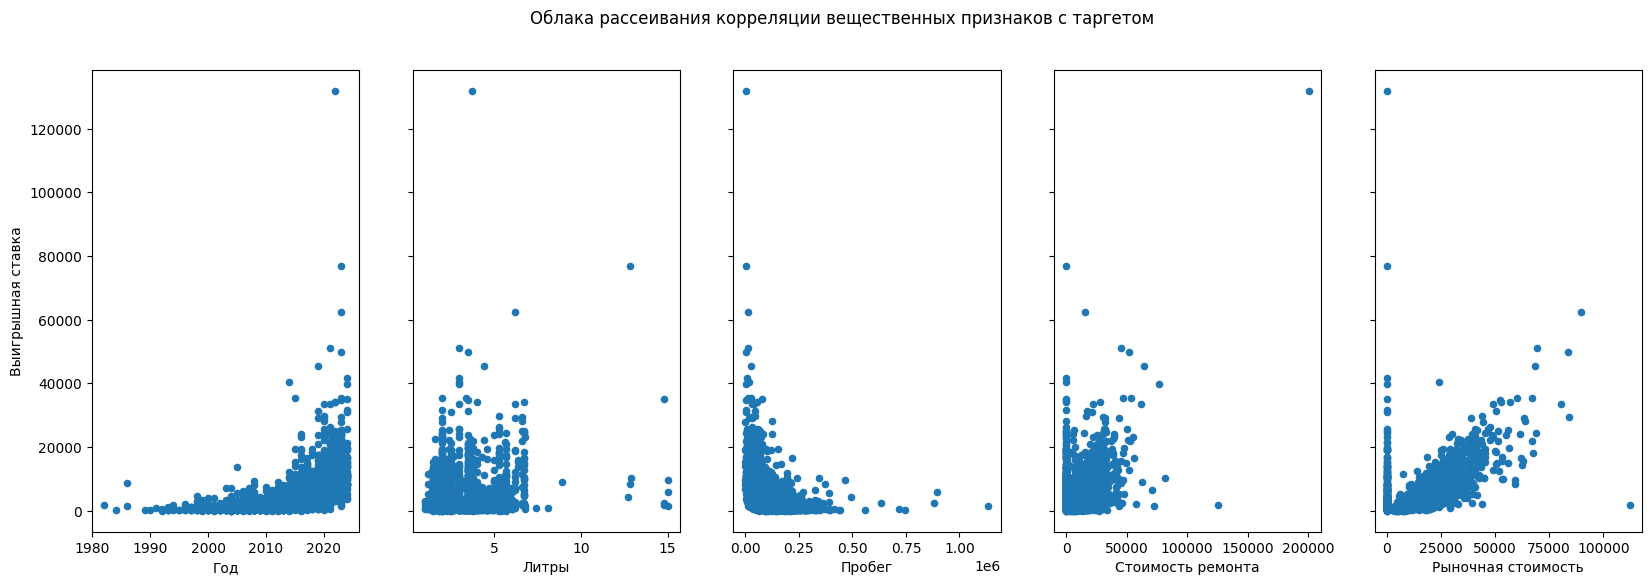

In [2035]:
fig, axs = plt.subplots(1, var_real.shape[0], sharey=True)
df.plot(kind='scatter', x=var_real[0], y=target, ax=axs[0], figsize=(20, 6))
df.plot(kind='scatter', x=var_real[1], y=target, ax=axs[1])
df.plot(kind='scatter', x=var_real[2], y=target, ax=axs[2])
df.plot(kind='scatter', x=var_real[3], y=target, ax=axs[3])
df.plot(kind='scatter', x=var_real[4], y=target, ax=axs[4])

#fig.supylabel('Target')
fig.suptitle('Облака рассеивания корреляции вещественных признаков с таргетом');

__Небольшой вывод:__ Автомобили с нулевой рыночной стоимостью можно назвать металлоломом, так как они используются скорее на запчасти, а не как цельный автомобиль. Связь же более пригодных к использованию автомобилей сильно похожа на линейную

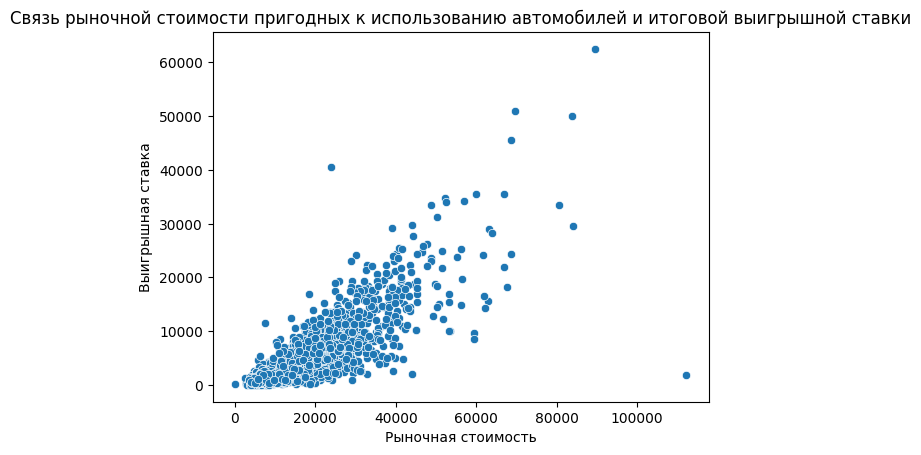

In [2036]:
sns.scatterplot(x = df[df['Рыночная стоимость'] != 0]['Рыночная стоимость'], y = df['Выигрышная ставка'])
plt.title('Связь рыночной стоимости пригодных к использованию автомобилей и итоговой выигрышной ставки');

## Корреляция вещественных переменных с логарифмом таргета

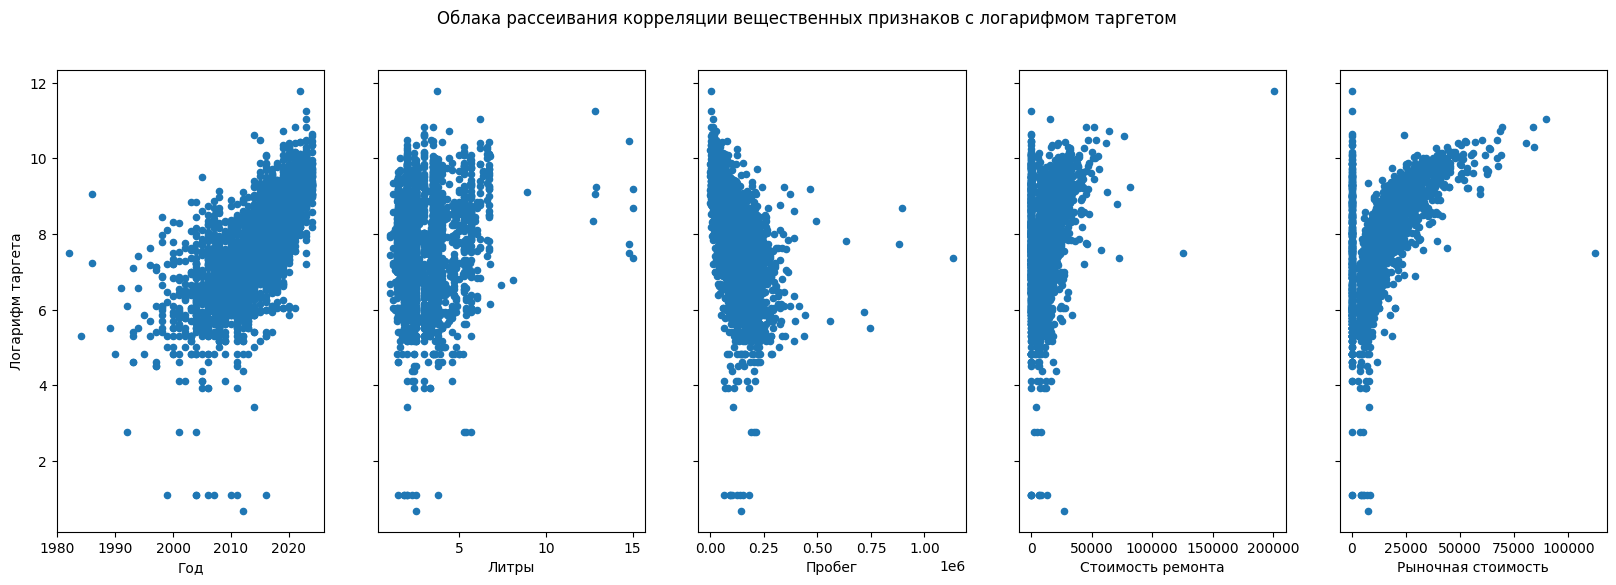

In [2037]:
fig, axs = plt.subplots(1, var_real.shape[0], sharey=True)
df.plot(kind='scatter', x=var_real[0], y='Логарифм таргета', ax=axs[0], figsize=(20, 6))
df.plot(kind='scatter', x=var_real[1], y='Логарифм таргета', ax=axs[1])
df.plot(kind='scatter', x=var_real[2], y='Логарифм таргета', ax=axs[2])
df.plot(kind='scatter', x=var_real[3], y='Логарифм таргета', ax=axs[3])
df.plot(kind='scatter', x=var_real[4], y='Логарифм таргета', ax=axs[4])

#fig.supylabel('Target')
fig.suptitle('Облака рассеивания корреляции вещественных признаков с логарифмом таргетом');

## Поиск зависимостей

### Рыночная стоимость 

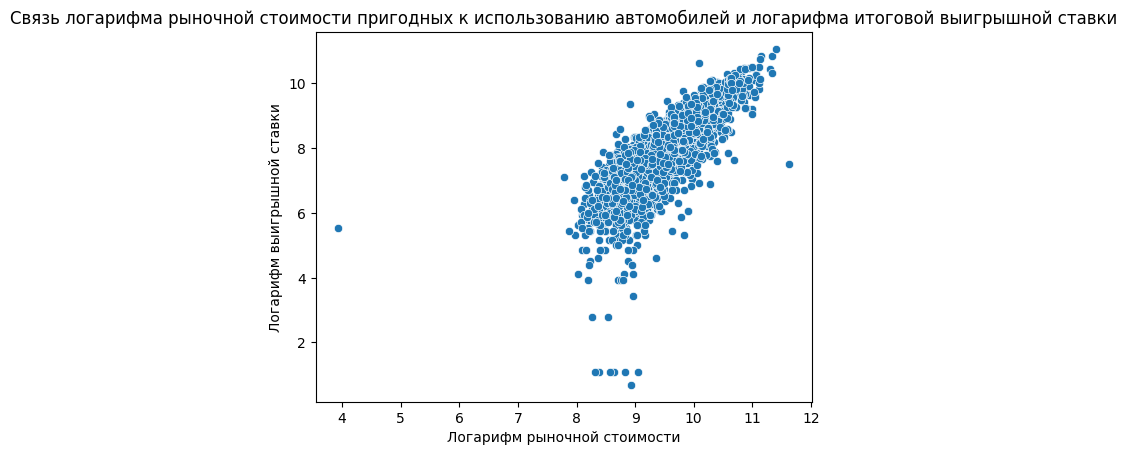

In [2038]:
sns.scatterplot(x = df[df['Рыночная стоимость'] != 0]['Рыночная стоимость'].apply(lambda x: np.log(1 + x)), y = df['Логарифм таргета'])
plt.ylabel('Логарифм выигрышной ставки')
plt.xlabel('Логарифм рыночной стоимости')
plt.title('Связь логарифма рыночной стоимости пригодных к использованию автомобилей и логарифма итоговой выигрышной ставки');

### Стоимость ремонта

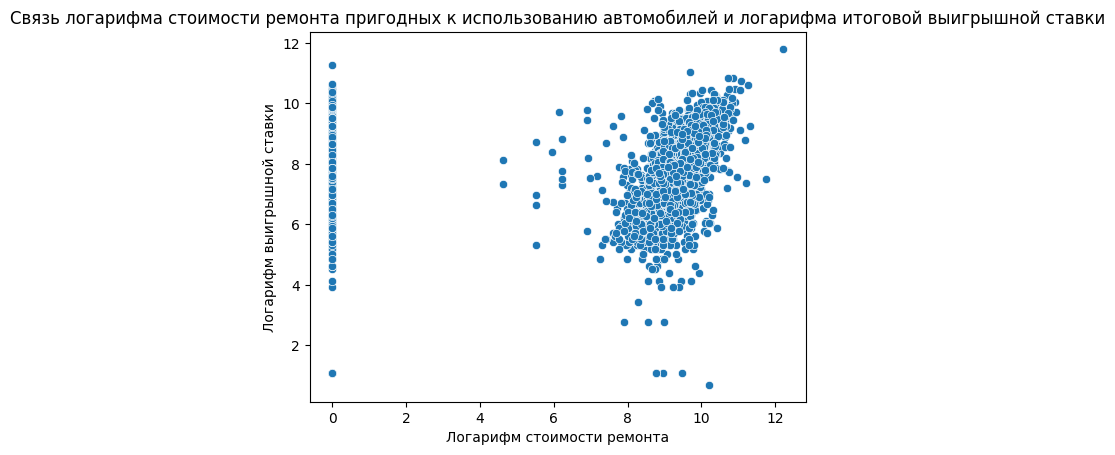

In [2039]:
sns.scatterplot(x = df['Стоимость ремонта'].apply(lambda x: np.log(1 + x)), y = df['Логарифм таргета'])
plt.ylabel('Логарифм выигрышной ставки')
plt.xlabel('Логарифм стоимости ремонта')
plt.title('Связь логарифма стоимости ремонта пригодных к использованию автомобилей и логарифма итоговой выигрышной ставки');

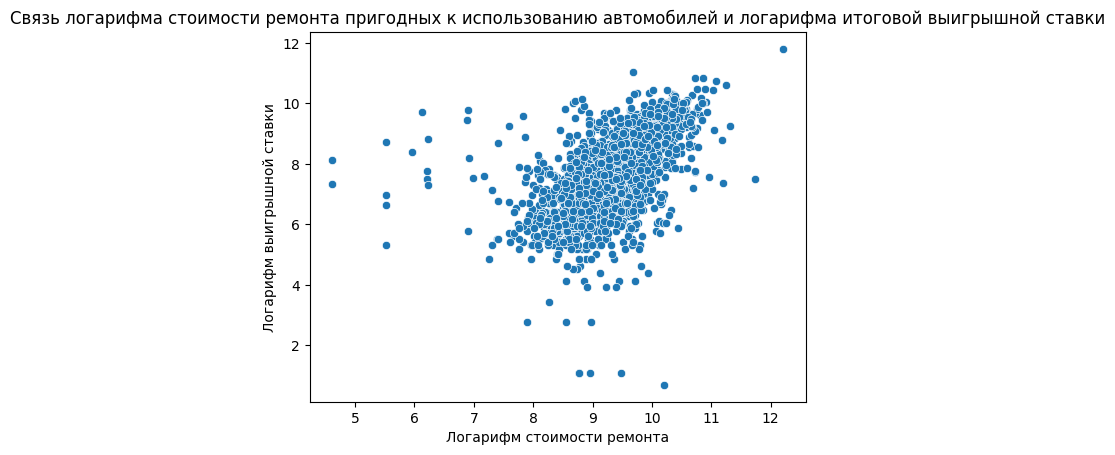

In [2040]:
sns.scatterplot(x = df[df['Стоимость ремонта'] != 0]['Стоимость ремонта'].apply(lambda x: np.log(1 + x)), y = df['Логарифм таргета'])
plt.ylabel('Логарифм выигрышной ставки')
plt.xlabel('Логарифм стоимости ремонта')
plt.title('Связь логарифма стоимости ремонта пригодных к использованию автомобилей и логарифма итоговой выигрышной ставки');

### Пробег

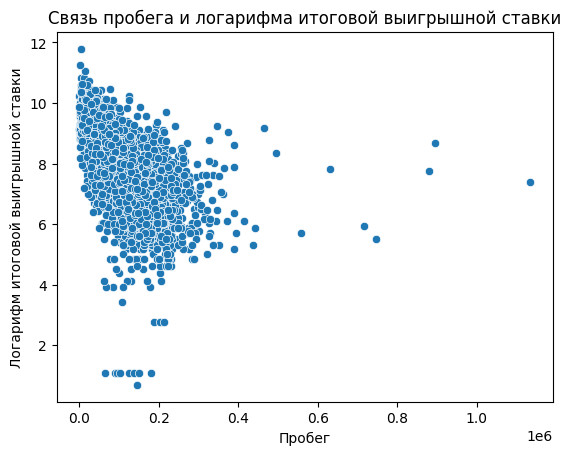

In [2041]:
sns.scatterplot(x = df['Пробег'], y = df['Логарифм таргета'])
plt.ylabel('Логарифм итоговой выигрышной ставки')
plt.xlabel('Пробег')
plt.title('Связь пробега и логарифма итоговой выигрышной ставки');

In [2042]:
df[var_real].corrwith(df['Логарифм таргета'])

Год                   0.681088
Литры                 0.099148
Пробег               -0.511140
Стоимость ремонта     0.367883
Рыночная стоимость    0.639129
dtype: float64

In [2043]:
df[df['Рыночная стоимость']!=0]['Рыночная стоимость'].apply(lambda x: np.log(1 + x)).corr(df['Логарифм таргета'])

0.7980913809403754

__Вывод:__ Обнаружена линейная связь переменных пробега, логарифма стоимости ремонта и логарифма рыночной стоимости от логарифма от выигрышной ставки.
* С пробегом наблюдается отрицательная связь: чем меньше пробег, тем больше стоит автомобиль
* Больше всего связь с логарифмом рыночной стоимости для машин, которые пригодны к дальнейшему использованию - корреляция равна 0.8 -> заметна линейная зависимость

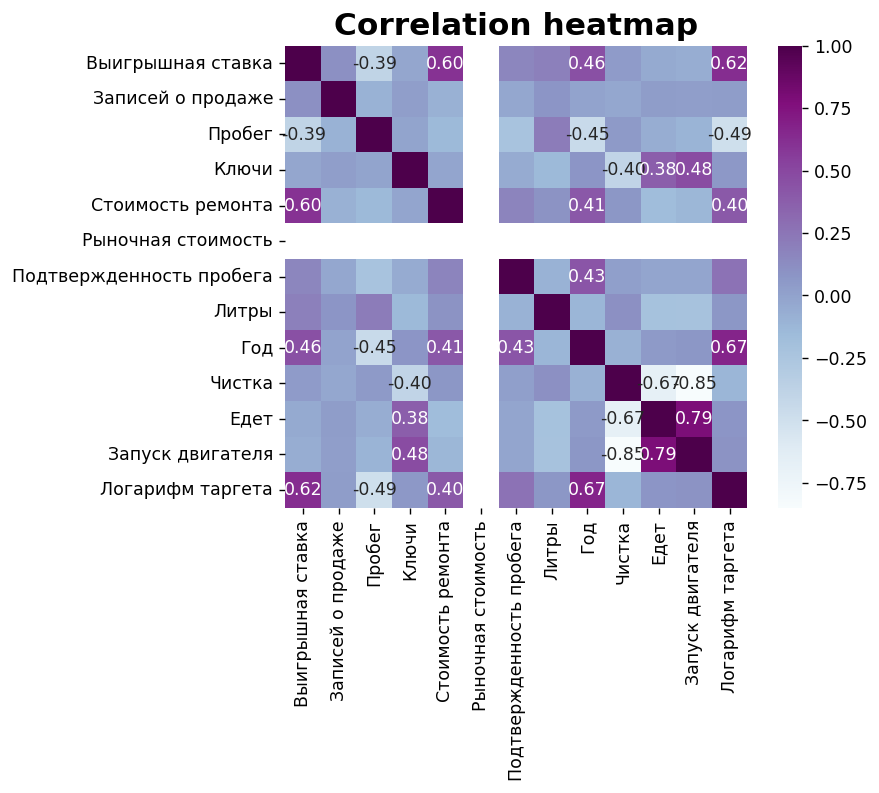

In [2044]:
# Исследуем отдельно автомобили с нулевой рыночной стоимостью
plt.figure(dpi=125)
ax = sns.heatmap(df[(df['Рыночная стоимость']==0)].corr(numeric_only= True), cmap="BuPu", annot=True, fmt="0.2f", square = True)
plt.title('Correlation heatmap', fontsize=18, fontweight="bold")
for t in ax.texts:
    if (float(t.get_text()) >= 0.3 or float(t.get_text()) <= -0.3) and t.get_position()[0] != t.get_position()[1]:
        t.set_text(t.get_text())
    else:
        t.set_text("")

__Небольшой вывод__: никаких дополнительных связей между нулевой рыночной стоимостью и другими переменными не обнаружено

In [2045]:
df[df['Рыночная стоимость']!=0]['Рыночная стоимость'].corr(df[df['Стоимость ремонта'] != 0]['Стоимость ремонта'])

0.7905755105542372

## Категориальные переменные

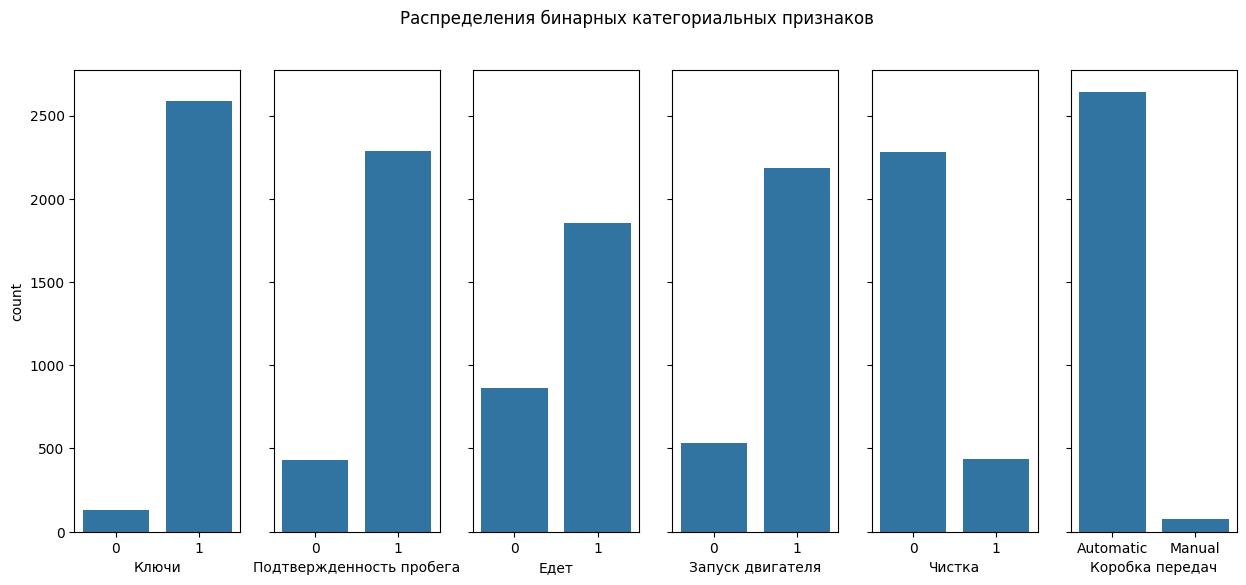

In [2046]:
var_analysis = np.array(['Ключи', 'Подтвержденность пробега', 'Едет', 'Запуск двигателя', 'Чистка', 'Коробка передач'])
fig, axs = plt.subplots(1, var_analysis.shape[0], sharey=True, figsize=(15, 6))
for i in range(len(var_analysis)):
    sns.countplot(df, x = var_analysis[i], ax = axs[i])

fig.suptitle('Распределения бинарных категориальных признаков');

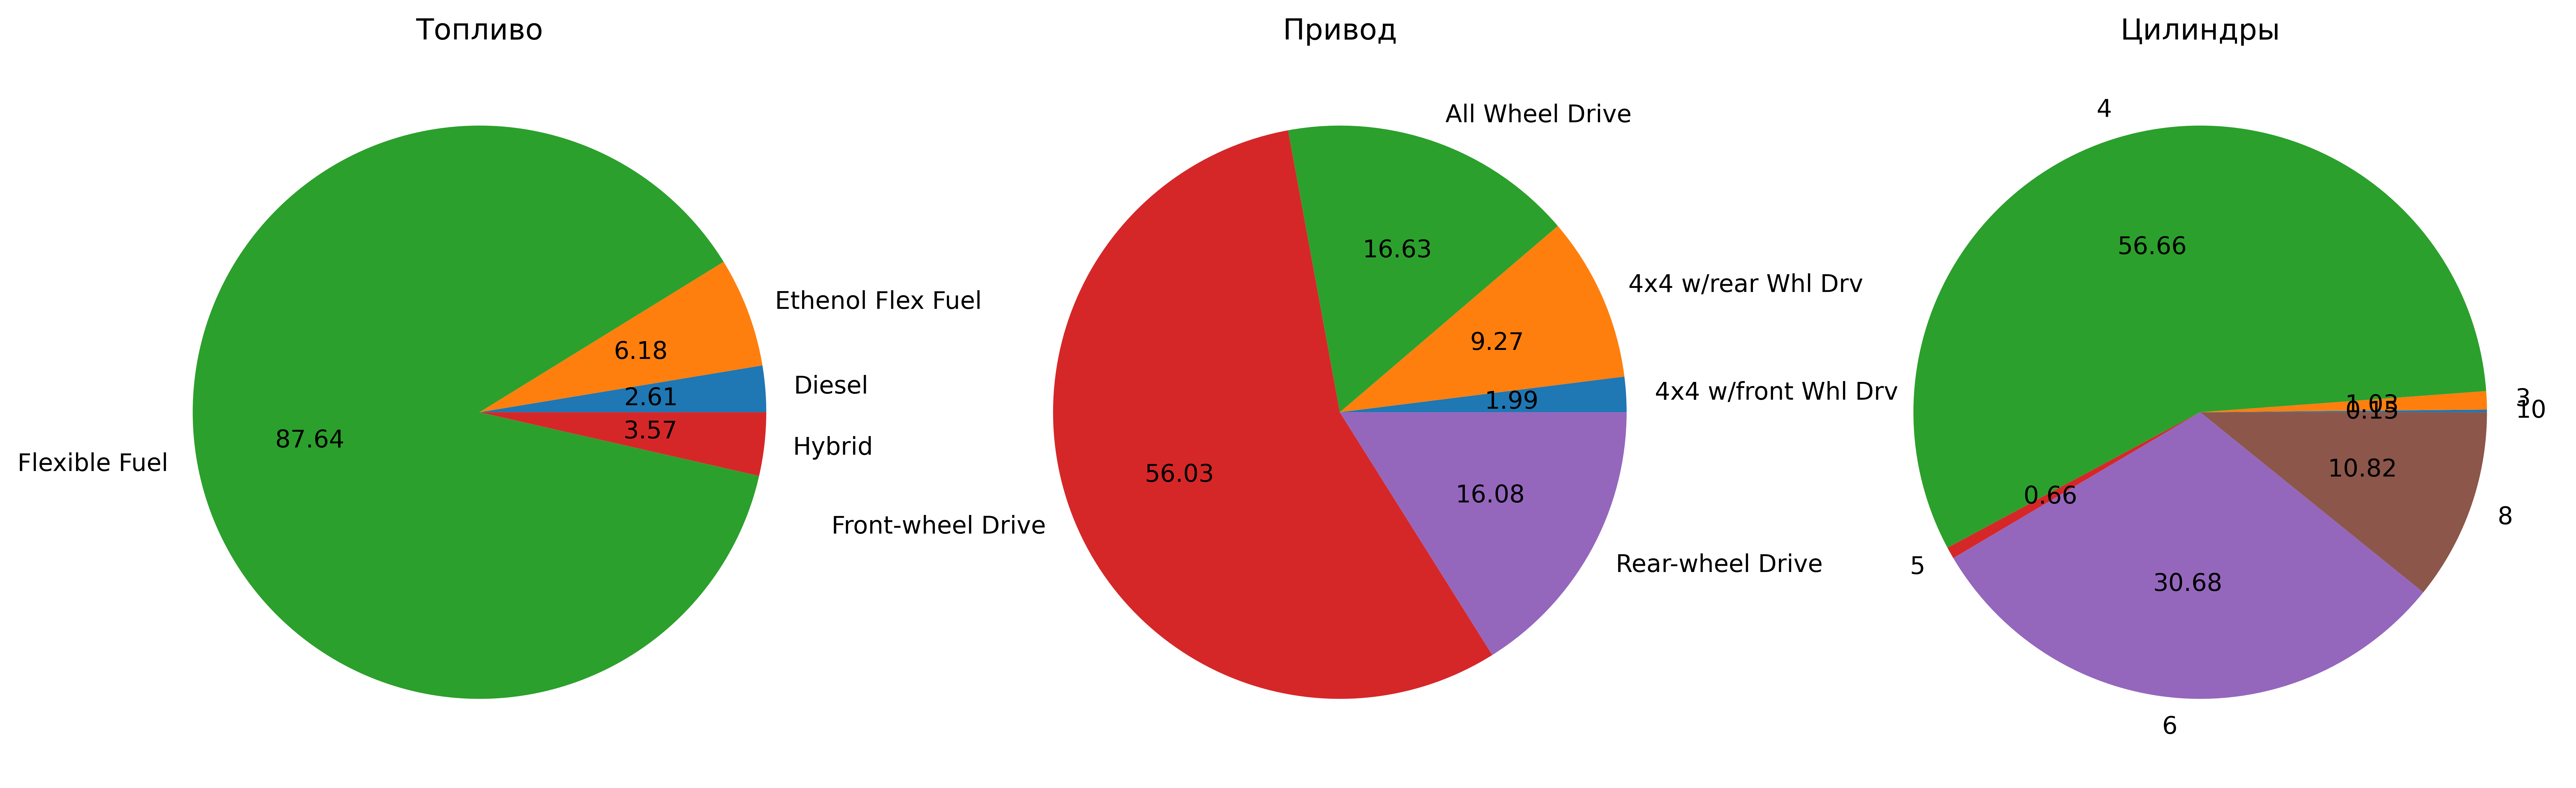

In [45]:
#df.groupby('Топливо').size().plot(kind='pie', autopct='%.2f');
fig = plt.figure(figsize=(18,15), dpi=600)
ax1 = plt.subplot2grid((1,3),(0,0))
plt.pie(df.groupby('Топливо').size(), labels = df.groupby('Топливо').size().index, autopct='%.2f')
plt.title('Топливо')

ax1 = plt.subplot2grid((1, 3), (0, 1))
plt.pie(df.groupby('Привод').size(), labels = df.groupby('Привод').size().index, autopct='%.2f')
plt.title('Привод')

ax1 = plt.subplot2grid((1, 3), (0, 2))
plt.pie(df.groupby('Цилиндры').size(), labels = df.groupby('Цилиндры').size().index, autopct='%.2f')
plt.title('Цилиндры');

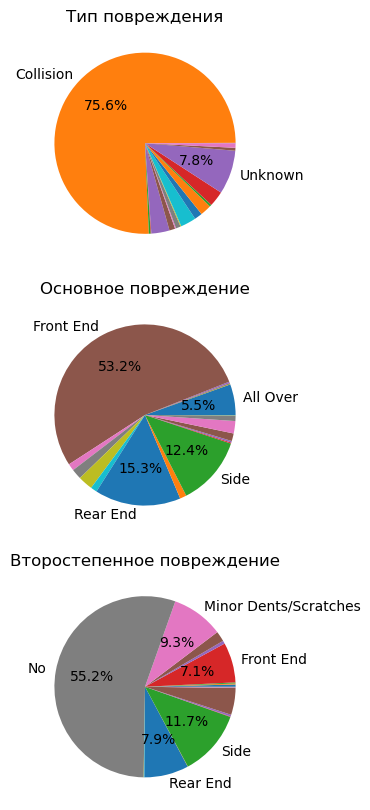

In [68]:
#df.groupby('Тип повреждения').size().plot(kind='pie', autopct=lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '');

def remove_labels(threshold, texts, autotexts):
    for label, pct_label in zip(texts, autotexts):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

fig, ax = plt.subplots(3, 1, figsize=(15, 10))

totals_df = df.groupby('Тип повреждения').size()
wedges, texts, autotexts = ax[0].pie(totals_df, labels=totals_df.index, autopct='%1.1f%%')
ax[0].set_title('Тип повреждения')
remove_labels(5, texts, autotexts)

wedges, texts, autotexts = ax[1].pie(df.groupby('Основное повреждение').size(), labels=df.groupby('Основное повреждение').size().index, autopct='%1.1f%%')
ax[1].set_title('Основное повреждение')
remove_labels(5, texts, autotexts)

wedges, texts, autotexts = ax[2].pie(df.groupby('Второстепенное повреждение').size(), labels=df.groupby('Второстепенное повреждение').size().index, autopct='%1.1f%%')
ax[2].set_title('Второстепенное повреждение')
remove_labels(5, texts, autotexts)

#ax[0].legend(bbox_to_anchor=(1.2, 1))
#ax[1].legend(bbox_to_anchor=(1.2, 1))
#ax[2].legend(bbox_to_anchor=(1.2, 1));

## Корреляция категорильных переменных с таргетом

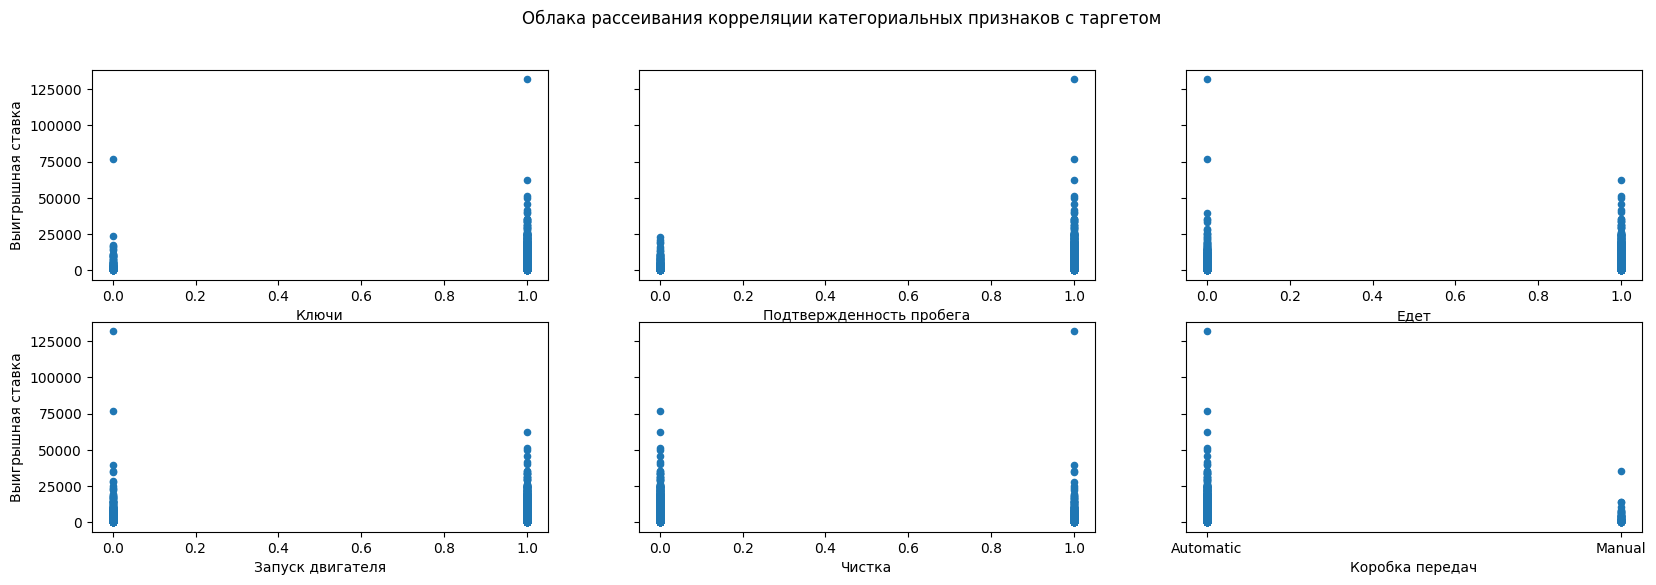

In [2049]:
var_analysis = np.array(['Ключи', 'Подтвержденность пробега', 'Едет', 'Запуск двигателя', 'Чистка', 'Коробка передач'])
fig, axs = plt.subplots(2, 3, sharey=True)    
df.plot(kind='scatter', x=var_analysis[0], y=target, ax=axs[0, 0], figsize=(20, 6))
df.plot(kind='scatter', x=var_analysis[1], y=target, ax=axs[0, 1])
df.plot(kind='scatter', x=var_analysis[2], y=target, ax=axs[0, 2])
df.plot(kind='scatter', x=var_analysis[3], y=target, ax=axs[1, 0])
df.plot(kind='scatter', x=var_analysis[4], y=target, ax=axs[1, 1])
df.plot(kind='scatter', x=var_analysis[5], y=target, ax=axs[1, 2])
#fig.supylabel('Target')
fig.suptitle('Облака рассеивания корреляции категориальных признаков с таргетом');

<Axes: xlabel='Цилиндры', ylabel='Выигрышная ставка'>

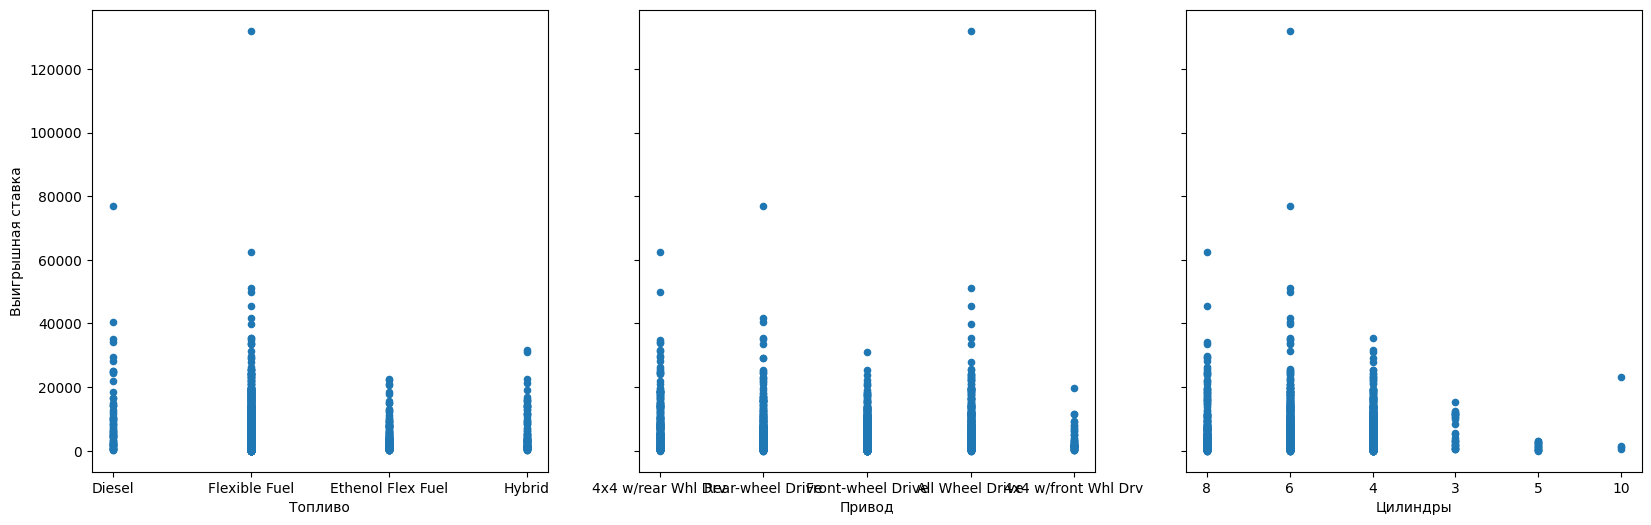

In [2050]:
var_analysis = np.array(['Топливо', 'Привод', 'Цилиндры'])
fig, axs = plt.subplots(1, 3, sharey=True)    
df.plot(kind='scatter', x=var_analysis[0], y=target, ax=axs[0], figsize=(20, 6))
df.plot(kind='scatter', x=var_analysis[1], y=target, ax=axs[1])
df.plot(kind='scatter', x=var_analysis[2], y=target, ax=axs[2])

<Axes: xlabel='Второстепенное повреждение', ylabel='Выигрышная ставка'>

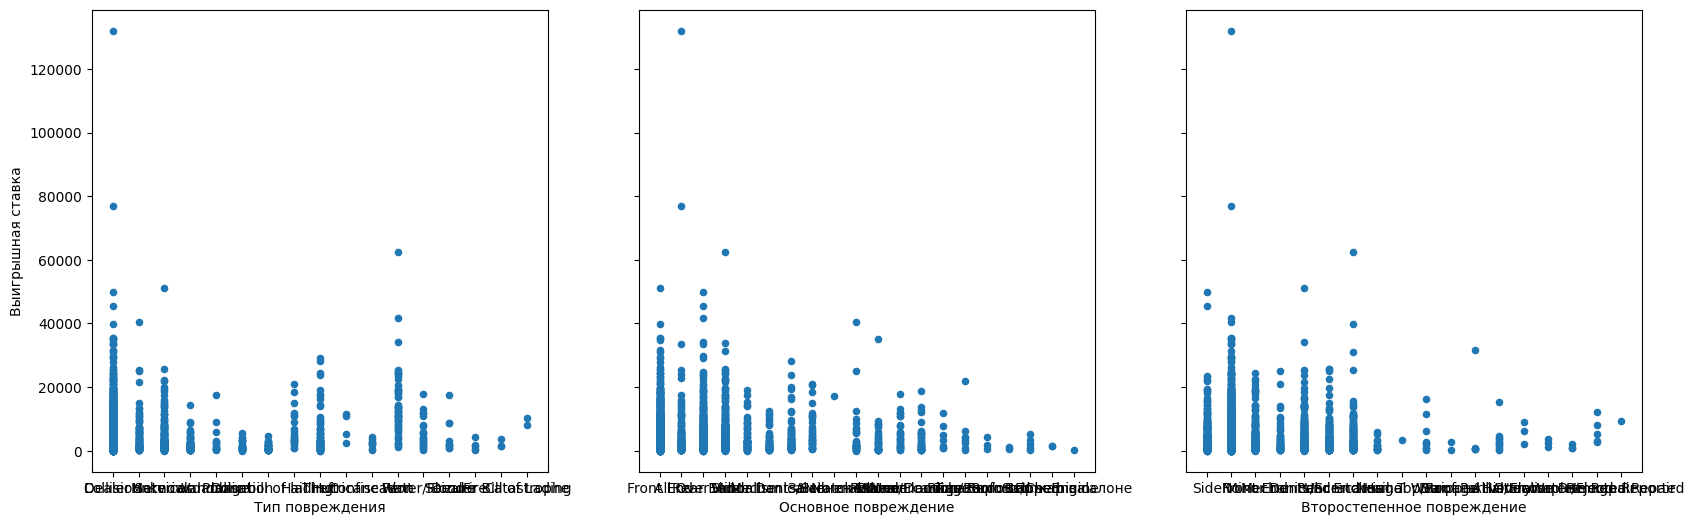

In [2051]:
var_analysis = np.array(['Тип повреждения', 'Основное повреждение', 'Второстепенное повреждение'])
fig, axs = plt.subplots(1, 3, sharey=True)    
df.plot(kind='scatter', x=var_analysis[0], y=target, ax=axs[0], figsize=(20, 6))
df.plot(kind='scatter', x=var_analysis[1], y=target, ax=axs[1])
df.plot(kind='scatter', x=var_analysis[2], y=target, ax=axs[2])

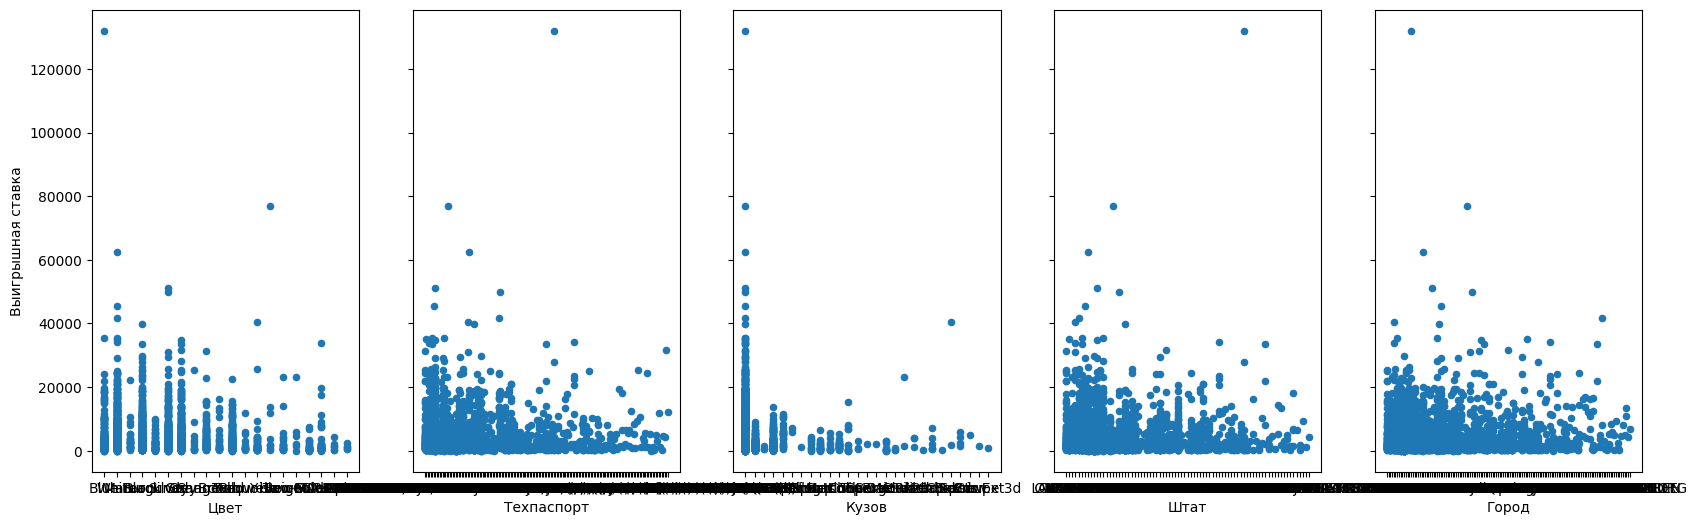

In [2052]:
var_analysis = np.array(['Цвет', 'Техпаспорт', 'Кузов', 'Штат', 'Город'])
fig, axs = plt.subplots(1, var_analysis.shape[0], sharey=True, figsize=(20, 6))    
for i in range(var_analysis.shape[0]):
    df.plot(kind='scatter', x=var_analysis[i], y=target, ax=axs[i])

In [2053]:
#Зависимость чистки и ключей
df['Ключи'].corr(df['Чистка'])

-0.3456463902609779

In [2054]:
df[df['Рыночная стоимость'] == 0]['Едет'].value_counts() #69% - машины, которые могут ехать

Едет
1    250
0    130
Name: count, dtype: int64

In [2055]:
print(df[df['Едет'] == 1]['Чистка'].unique()) #автомобили, которые более всего работоспособны (едут), не чистят
print(df[df['Запуск двигателя'] == 1]['Чистка'].unique()) #автомобили, у которых запускается двигатель, не чистят

[0]
[0]


### Машины, которые могут ехать

In [2056]:
df_new = df[df['Едет'] == 1]

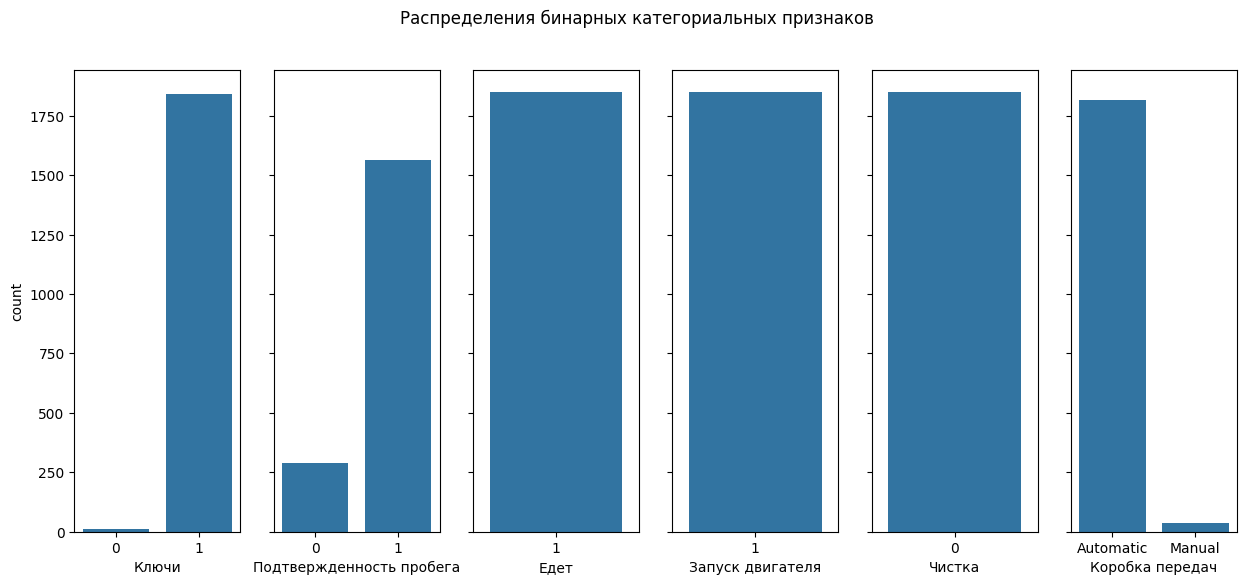

In [2057]:
var_analysis = np.array(['Ключи', 'Подтвержденность пробега', 'Едет', 'Запуск двигателя', 'Чистка', 'Коробка передач'])
fig, axs = plt.subplots(1, var_analysis.shape[0], sharey=True, figsize=(15, 6))
for i in range(len(var_analysis)):
    sns.countplot(df_new, x = var_analysis[i], ax = axs[i])

fig.suptitle('Распределения бинарных категориальных признаков');

In [2058]:
df[df['Едет'] == 1]['Ключи'].value_counts()

Ключи
1    1842
0      10
Name: count, dtype: int64

__Интересные факты:__
* Автомобили, у которых запускается двигатель, не чистят и не приводят в товарный вид. Также не чистят и автомобили, которые способны ехать
* Среди машин с нулевой рыночной стоимостью 69% - это те машины, которые работоспособны и могут ехать
* Отрицательная зависимость наличия ключей и проведения чистки: если ключи есть, чистку проводят в 11% случаях; когда ключей нет, чистку проводят в 77% случаях
* У машин, которые способны ехать, в основном имеются в наличии ключи. Отсутствие ключей в основном приходится на машины, которые не способны ехать
* Среди машин, которые могут ехать, встречаются те, которые имеют нулевую рыночную стоимость

__Небольшое summary:__ Если машина способна ехать, у нее, во-первых, имеются ключи, во-вторых, в ней скорее всего не проведена чистка. Если машина не может ехать, то в ней скорее всего проведена чистка

In [2059]:
#повреждений передней части, когда причина - автомобильная авария
df[df['Тип повреждения'] == 'Collision']['Основное повреждение'].value_counts()['Front End'] / np.sum(df[df['Тип повреждения'] == 'Collision']['Основное повреждение'].value_counts())

0.594647201946472

In [2060]:
#повреждений передней части, когда причина - не автомобильная авария
df[df['Тип повреждения'] != 'Collision']['Основное повреждение'].value_counts()['Front End'] / np.sum(df[df['Тип повреждения'] != 'Collision']['Основное повреждение'].value_counts())

0.33634992458521873

In [2061]:
print('Доля машин без второстепенного повреждения')
print(df['Второстепенное повреждение'].value_counts()['No'] / np.sum(df['Второстепенное повреждение'].value_counts()))

Доля машин без второстепенного повреждения
0.5518763796909493


In [2062]:
print('Доля машин из автомобильной аварии с второстепенным повреждением')
print(df[df['Тип повреждения'] == 'Collision']['Второстепенное повреждение'].value_counts()['No'] / np.sum(df[df['Тип повреждения'] == 'Collision']['Второстепенное повреждение'].value_counts()))
print('Доля машин не из автомобильной аварии с второстепенным повреждением')
print(df[df['Тип повреждения'] != 'Collision']['Второстепенное повреждение'].value_counts()['No'] / np.sum(df[df['Тип повреждения'] != 'Collision']['Второстепенное повреждение'].value_counts()))

Доля машин из автомобильной аварии с второстепенным повреждением
0.5430656934306569
Доля машин не из автомобильной аварии с второстепенным повреждением
0.579185520361991


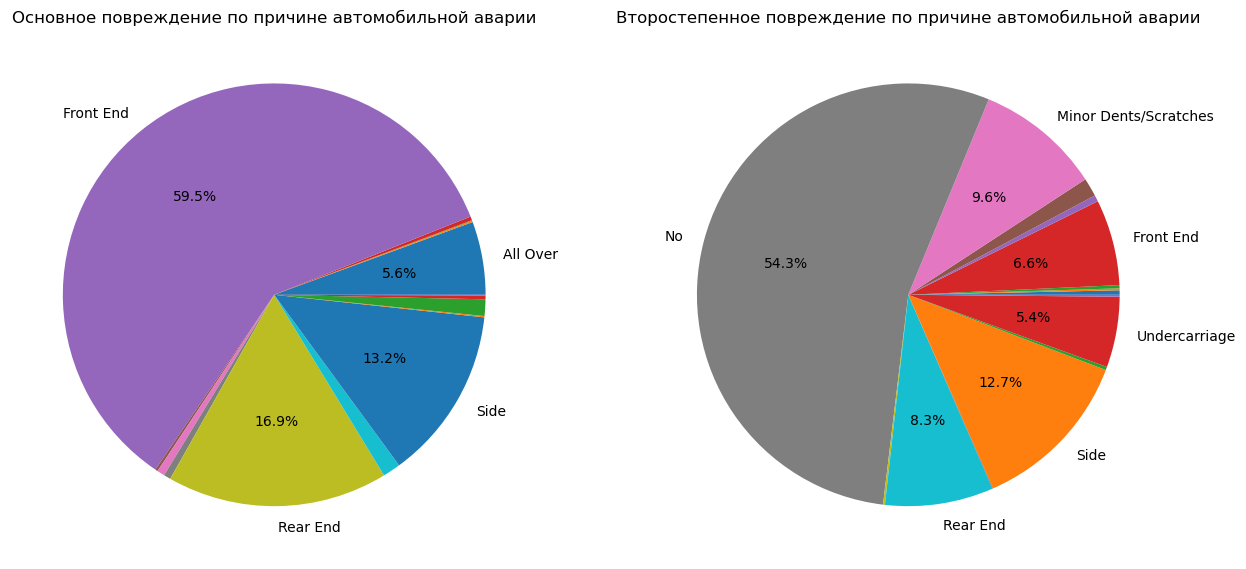

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

totals_df = df[(df['Тип повреждения'] == 'Collision')].groupby('Основное повреждение').size()
wedges, texts, autotexts = ax[0].pie(totals_df, labels=totals_df.index, autopct='%1.1f%%')
ax[0].set_title('Основное повреждение по причине автомобильной аварии')
remove_labels(5, texts, autotexts)

totals_df = df[(df['Тип повреждения'] == 'Collision')].groupby('Второстепенное повреждение').size()
wedges, texts, autotexts = ax[1].pie(totals_df, labels=totals_df.index, autopct='%1.1f%%')
ax[1].set_title('Второстепенное повреждение по причине автомобильной аварии')
remove_labels(5, texts, autotexts)

#df[(df['Тип повреждения'] == 'Collision')].groupby('Основное повреждение').size().plot(kind='pie', autopct=lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '')

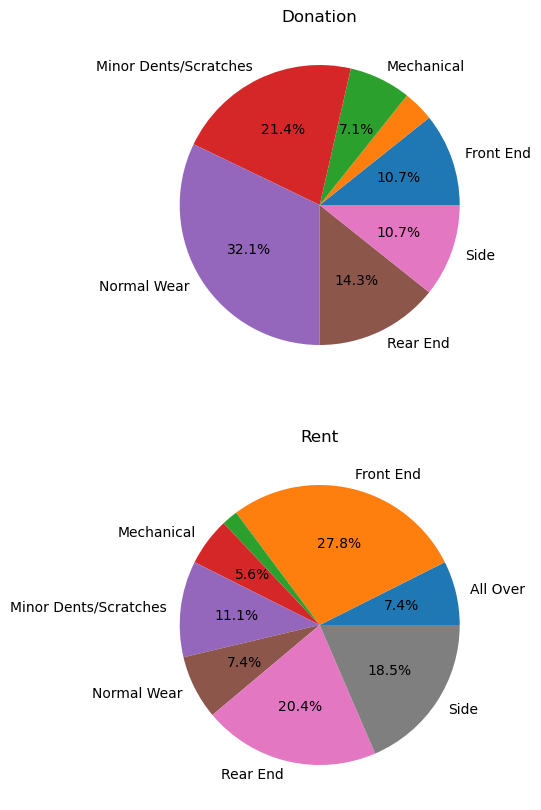

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
types = ['Donation', 'Rent']
cnt = 0
for type_of_damage in types:
    totals_df = df[df['Тип повреждения'] == type_of_damage].groupby('Основное повреждение').size()
    wedges, texts, autotexts = ax[cnt].pie(totals_df, labels=totals_df.index, autopct='%1.1f%%')
    ax[cnt].set_title(type_of_damage)
    remove_labels(5, texts, autotexts)
    cnt+=1

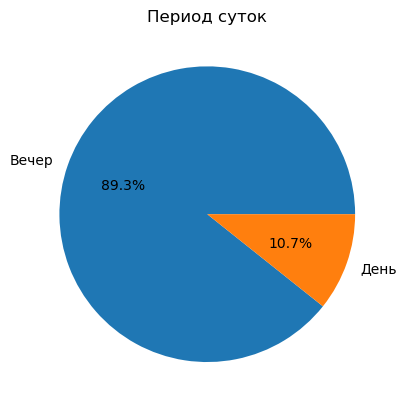

In [103]:
plt.title('Период суток')
df.groupby('Период суток').size().plot(kind='pie', autopct='%1.1f%%');

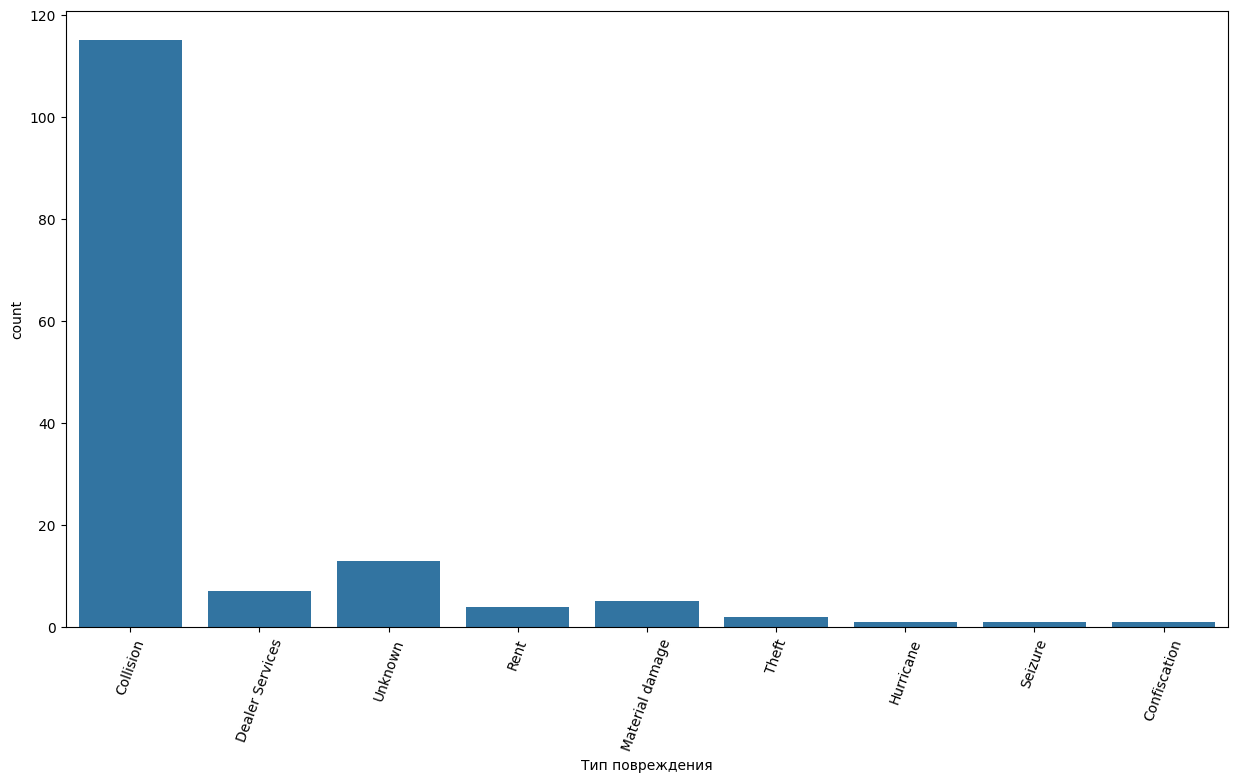

In [2065]:
plt.figure(figsize = (15, 8))
sns.countplot(df[df['Основное повреждение'] == 'All Over'], x = 'Тип повреждения')
plt.xticks(rotation = 70);

__Другие факты:__
* Большинство причин повреждений - автомобильные аварии, при этом в 60% случаев повреждается передняя часть. Если причина повреждения другая, то передняя часть повреждается в 44% случаев. 
* В целом, второстепенное повреждение имеют около 50% машин, при этом наличие второстепенного повреждения не зависит от того, автомобильная это авария или нет
* Чаще всего в автомобильных авариях первостепенное повреждение приходится на перед, второстепенное - на заднюю часть
* Повсеместные повреждения распространены в таких типах аварий, как автомобильные авария, кража, изъятия, конфискация, аренда и дилерские услуги. Чаще всего они встречаются в автомобильных авариях

__Общие характеристики аукциона:__
* В большинстве случае продавцы продают машины вместе с ключами. В случае, если это не автомобильная авария, тогда в таких случаях преобладают повреждения "вандализм" и повреждения передней части
* В большинстве случае пробег подтвержден, зависимости его подтвержденности с типом повреждения нет. Чаще всего пробег подтверждается при наличии ключей
* Распространены машины с передним приводом, 4 цилиндрами, автоматической коробкой передач . Так распространены те машины, которые используют бензин
* В основном продают машины, которые могут ехать
* Больше всего продажи совершаются вечером

# Тестирование гипотез

### Гипотезы о таргете

__Первая гипотеза для проверки__: Гипотеза о распределении: нулевая гипотеза состоит в том, что случайная величина X имеет нормальное распределение. Первая гипотеза - о том, что она имеет другое распределение из семейства распределений $\mathcal{F}_\theta(x)$. Проверяется для случайных величин:выигрышная ставка и логарифм выигрышной ставки

__Критерий__: Критерий Шапиро-Уилка

$$
H_0: X \sim N(\mu, \sigma^2) \\
H_1: X \sim \mathcal{F}_\theta(x)
$$

In [142]:
alpha = 0.05

#для таргета
print(shapiro(df["Выигрышная ставка"]))

# Попробуем проверить эту гипотезу на логарифме таргета
df["Лог выигрышной ставки"]=df["Выигрышная ставка"].apply(lambda x: np.log(1 + x))
print(shapiro(df[["Лог выигрышной ставки"]]))

ShapiroResult(statistic=0.6050699949264526, pvalue=0.0)
ShapiroResult(statistic=0.975369393825531, pvalue=2.8718103358642898e-21)


__Вывод:__ Нулевая гипотеза о том, что таргет или логарифм таргета распределены нормально, опровергается, так как p_value значительно меньше 0.05. Значит, таргет не имеет нормального распределения. 

__Вторая гипотеза для проверки__: Цена продажи (выигрышная ставка) вечером выше, чем в остальное время суток, вследствие повышенного спроса,вызванного повышенной активностью скупщиков именно вечером

__Критерий__: z-критерий при предпосылках, что выборки по продажам днем и вечером независимы, выборка состоит из независимых. одинаково распределенных случайных величин, количество наблюдений достаточное для применения асимптотики. 

$X$ - выборка по продажам вечером, $Y$ - выборка по продажам днем
$$
H_0: \mu_X - \mu_Y = 0 \\
H_1: \mu_X - \mu_Y \ne 0
$$

In [126]:
alpha = 0.05

avg_dif = df[df['Период суток'] == 'Вечер']['Выигрышная ставка'].mean() - df[df['Период суток'] == 'День']['Выигрышная ставка'].mean()
n_x = df[df['Период суток'] == 'Вечер']['Выигрышная ставка'].count()
n_y = df[df['Период суток'] == 'День']['Выигрышная ставка'].count()
std_hat =  np.sqrt(df[df['Период суток'] == 'Вечер']['Выигрышная ставка'].var() / n_x + df[df['Период суток'] == 'День']['Выигрышная ставка'].var() / n_y)
z_obs = avg_dif / std_hat
z_crit_right = stats.norm.ppf(1 - alpha/2)
print('Наблюдаемое значение: ', z_obs)
print(f'Значения критерия: {-z_crit_right} и {z_crit_right}')

Наблюдаемое значение:  -4.917015934079221
Значения критерия: -1.959963984540054 и 1.959963984540054


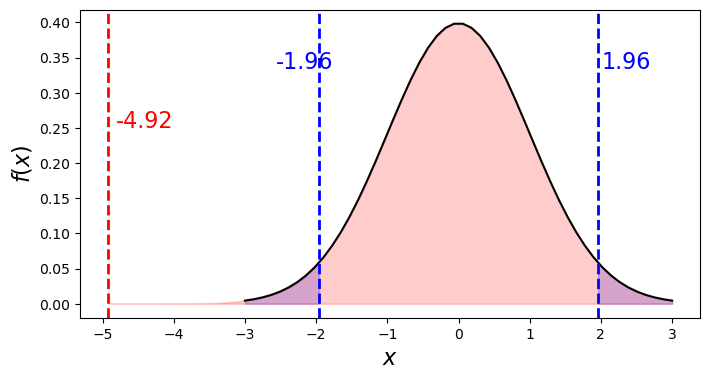

In [122]:
margin = 3
p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
z_crit = stats.norm().ppf(1 - alpha/2)

statistics = ['-z_crit', 'z_crit',  'z_obs']
params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                               (z_crit, 0.05, z_crit, margin, 'b'),
                            
                               (z_obs, 0.1, z_obs, margin, 'r')]))
plt.figure(figsize = (8, 4))
x = np.linspace(-margin, margin)
pdf = stats.norm().pdf(x)

plt.plot(x, pdf, color="black")
plt.ylabel("$f(x)$", fontsize=16)
plt.xlabel("$x$", fontsize=16)
y_max = plt.ylim()[1]

for i in range(len(statistics)):
    statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]

    plt.axvline(statistic, color=color, linestyle="--", lw=2)
    h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
    plt.text(statistic + text_margin, 
             h*y_max, round(statistic, 2), color=color, fontsize=16)

    xq = np.linspace(left_bound, right_bound)
    yq = stats.norm().pdf(xq)
    plt.fill_between(xq, 0, yq, color=color, alpha=0.2)


__Вывод__: Гипотеза о равенстве средних выигрышных ставок в разное время суток отверглась. Однако данные показывают, что выигрышная ставка скорее больше днем, чем вечером, поэтому разница средних выигрышных ставок получилась отрицательная

In [143]:
#Критерий Манна-Уитни
daytime_bets = df[df['Период суток'] == "День"]["Выигрышная ставка"]
evening_bets = df[df['Период суток'] == "Вечер"]["Выигрышная ставка"]
print(stats.mannwhitneyu(daytime_bets, evening_bets))
# Нулевая гипотеза не отвергается - период суток воздействует на выигрышую ставку

MannwhitneyuResult(statistic=417713.0, pvalue=3.298923073632642e-07)


In [2068]:
# Теперь попробуем проверить, есть ли статистически значимая разница в средних/медианах выигрышной ставки относительно дня недель. Мы уже знаем, что распределение выигрышной ставки не близко к нормальному, поэтому будем 
# использовать непараметрический аналог ANOVA - Критерий Краскела-Уоллиса.
mon_bets = df[df['День недели'] == "Понедельник"]["Выигрышная ставка"]
tue_bets = df[df['День недели'] == "Вторник"]["Выигрышная ставка"]
wed_bets = df[df['День недели'] == "Среда"]["Выигрышная ставка"]
thu_bets = df[df['День недели'] == "Четверг"]["Выигрышная ставка"]
fri_bets = df[df['День недели'] == "Пятница"]["Выигрышная ставка"]
print(stats.kruskal(mon_bets, tue_bets, wed_bets, thu_bets, fri_bets))
# p_value больше выбранного уровня значимости, а значит нулевая гипотеза о незначимости влияния дня на выигрышную ставку, отвергается. Теперь посмотрим, между какими конкретно группами существую различия.
for i, group1 in enumerate([mon_bets, tue_bets, wed_bets, thu_bets, fri_bets]):
    for j, group2 in enumerate([mon_bets, tue_bets, wed_bets, thu_bets, fri_bets]):
        if i < j:
            U, p = stats.mannwhitneyu(group1, group2)
            if p < 0.05:
                print(f"Группа {i+1} vs Группа {j+1}: U={U:.2f}, p={p:.4f}")
                print("Различие статистически значимо")
# То есть в среду выигрышная ставка выше, чем в пятницу(?), а так как среда одновременно разница нестатистически значима для среды с остальными днями и для пятницы с остальными днями, 

KruskalResult(statistic=7.285088193138526, pvalue=0.12156799003878337)
Группа 3 vs Группа 5: U=188015.00, p=0.0295
Различие статистически значимо


In [2069]:
# Посмотрим критерий Манна-Уитнии и Краскела-Уоллиса для некоторых других переменных и таргета
group1 = df[df["Едет"] == 1]["Выигрышная ставка"]
group2 = df[df["Едет"] == 0]["Выигрышная ставка"]
print(stats.mannwhitneyu(group1, group2))

group1 = df[df["Коробка передач"] == "Automatic"]["Выигрышная ставка"]
group2 = df[df["Коробка передач"] == "Manual"]["Выигрышная ставка"]
print(stats.mannwhitneyu(group1, group2))

group1 = df[df["Запуск двигателя"] == 1]["Выигрышная ставка"]
group2 = df[df["Запуск двигателя"] == 0]["Выигрышная ставка"]
print(stats.mannwhitneyu(group1, group2))


MannwhitneyuResult(statistic=961413.5, pvalue=5.910915919159694e-17)
MannwhitneyuResult(statistic=118058.5, pvalue=0.002378354194583443)
MannwhitneyuResult(statistic=721535.0, pvalue=2.274730215363454e-18)


In [2070]:
list1=[]
for fuel_type in df["Топливо"].unique():
    list1.append(df[df["Топливо"] == fuel_type]["Выигрышная ставка"])
print(stats.kruskal(*list1))

list2=[]
for _ in df["Привод"].unique():
    list2.append(df[df["Привод"] == _]["Выигрышная ставка"])
print(stats.kruskal(*list2))

list3=[]
for _ in df["Техпаспорт"].unique():
    list3.append(df[df["Техпаспорт"] == _]["Выигрышная ставка"])
print(stats.kruskal(*list3))

list4=[]
for _ in df["Цилиндры"].unique():
    list4.append(df[df["Цилиндры"] == _]["Выигрышная ставка"])
print(stats.kruskal(*list4))

# Везде различия статистически значимы

KruskalResult(statistic=46.437089596372395, pvalue=4.578825207386391e-10)
KruskalResult(statistic=214.96591168037708, pvalue=2.2704235866953417e-45)
KruskalResult(statistic=405.82599692769986, pvalue=1.6743709719636147e-22)
KruskalResult(statistic=22.16664005201917, pvalue=0.00048674937617680555)


### Тестирование гипотез второго типа, не связанные с таргетом

In [2071]:
# Теперь мы будем строить гипотезы о различиях между категориальными признаками и не-таргетом. Для этого будем пробовать использовать t-test и Хи-квадрат

In [2072]:
print(shapiro(df["Стоимость ремонта"]))
print(shapiro(df["Рыночная стоимость"]))
print(shapiro(df["Год"]))
print(shapiro(df["Пробег"]))
print(shapiro(df["Литры"]))
# t-test не применим

ShapiroResult(statistic=0.7861943938833738, pvalue=7.514486337137144e-51)
ShapiroResult(statistic=0.8684490812653504, pvalue=4.848006390545325e-43)
ShapiroResult(statistic=0.9559450491993596, pvalue=6.436028980566589e-28)
ShapiroResult(statistic=0.8710562670391908, pvalue=9.839761061949947e-43)
ShapiroResult(statistic=0.7961267814460093, pvalue=4.683849469479027e-50)


In [2073]:
contingency_table = pd.crosstab(df['Второстепенное повреждение'], df['Основное повреждение'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(chi2, p_value )
#Существует статистически значимая взаимосвязь между второстепенным и основным повреждением, что логично


contingency_table = pd.crosstab(df['Запуск двигателя'], df['Едет'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(chi2, p_value )

contingency_table = pd.crosstab(df['Привод'], df['Запуск двигателя'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(chi2, p_value )

contingency_table = pd.crosstab(df['Основное повреждение'], df['Едет'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(chi2, p_value )


var_cat = np.array(['Марка', 'День недели', 'Период суток', 'Цвет', 'Коробка передач', 'Топливо', 'Привод', 'Техпаспорт', 'Тип повреждения', 'Основное повреждение', 
           'Второстепенное повреждение', 'Ключи', 'Кузов', 'Подтвержденность пробега', 'Цилиндры', 'Штат', 'Город', 'Чистка', 
          'Едет', 'Запуск двигателя', 'Записей о продаже'])

# Везде статистически значимая взаимосвязь - надо подумать как интерпретировать + между чем и чем еще посмотреть !!!

952.4602231242401 2.326868829920785e-63
1404.0988164115104 2.7023927161546322e-307
16.907559828859313 0.002014538258495785
173.043243021104 7.20118379179924e-27


In [2074]:
var_real = np.array(['Год', 'Литры', 'Пробег', 'Стоимость ремонта', 'Рыночная стоимость'])

list1=[]
for _ in df["Основное повреждение"].unique():
    list1.append(df[df["Основное повреждение"] == _]["Стоимость ремонта"])
print(stats.kruskal(*list1))
#статистически значимо

list2=[]
for _ in df["Едет"].unique():
    list2.append(df[df["Едет"] == _]["Год"])
print(stats.kruskal(*list2))
# статистически не значимо

list3=[]
for _ in df["Марка"].unique():
    list3.append(df[df["Марка"] == _]["Стоимость ремонта"])
print(stats.kruskal(*list3))
#статистически значимо

#подумать, что бы еще посравннивать + интерпретации!!!

KruskalResult(statistic=204.38356179312748, pvalue=4.5645688967627464e-33)
KruskalResult(statistic=0.06041601344892993, pvalue=0.8058396184741757)
KruskalResult(statistic=107.80145516486559, pvalue=2.8385701364864446e-07)


### Тестирование гипотез второго типа, не связанные со сравнением теоретического и эмпирического распределений

Распределение столбца 'Рыночная стоимость' не соответствует теоретическому распределению chi-square.
Распределение столбца 'Рыночная стоимость' не соответствует теоретическому распределению Фишера.
Распределение столбца 'Рыночная стоимость' не соответствует теоретическому экспоненциальному распределению.
Распределение столбца 'Рыночная стоимость' не соответствует теоретическому гамма-распределению.


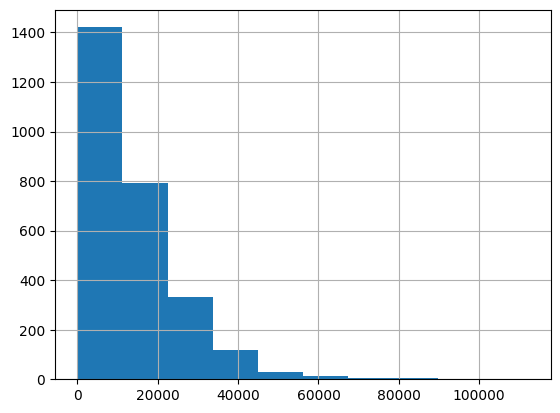

In [2075]:
df["Рыночная стоимость"].hist()
market_value = df["Рыночная стоимость"]

stat, p_value = stats.ks_2samp(market_value, stats.chi2.rvs(df=len(market_value)-1, size=len(market_value)))
if p_value < 0.05:
    print("Распределение столбца 'Рыночная стоимость' не соответствует теоретическому распределению chi-square.")
else:
    print("Распределение столбца 'Рыночная стоимость' соответствует теоретическому распределению chi-square.")


stat, p_value = stats.ks_2samp(market_value, stats.f.rvs(dfn=len(market_value)-1, dfd=len(market_value)-1, size=len(market_value)))
if p_value < 0.05:
    print("Распределение столбца 'Рыночная стоимость' не соответствует теоретическому распределению Фишера.")
else:
    print("Распределение столбца 'Рыночная стоимость' соответствует теоретическому распределению Фишера.")


stat, p_value = stats.ks_2samp(market_value, stats.expon.rvs(scale=1/market_value.mean(), size=len(market_value)))
if p_value < 0.05:
    print("Распределение столбца 'Рыночная стоимость' не соответствует теоретическому экспоненциальному распределению.")
else:
    print("Распределение столбца 'Рыночная стоимость' соответствует теоретическому экспоненциальному распределению.")


shape, loc, scale = stats.gamma.fit(market_value)
stat, p_value = stats.ks_2samp(market_value, stats.gamma.rvs(a=shape, loc=loc, scale=scale, size=len(market_value)))
if p_value < 0.05:
    print("Распределение столбца 'Рыночная стоимость' не соответствует теоретическому гамма-распределению.")
else:
    print("Распределение столбца 'Рыночная стоимость' соответствует теоретическому гамма-распределению.")


Распределение столбца 'Стоимость ремонта' не соответствует теоретическому распределению chi-square.
Распределение столбца 'Стоимость ремонта' не соответствует теоретическому распределению Фишера.
Распределение столбца 'Стоимость ремонта' не соответствует теоретическому экспоненциальному распределению.
Распределение столбца 'Стоимость ремонта' не соответствует теоретическому гамма-распределению.


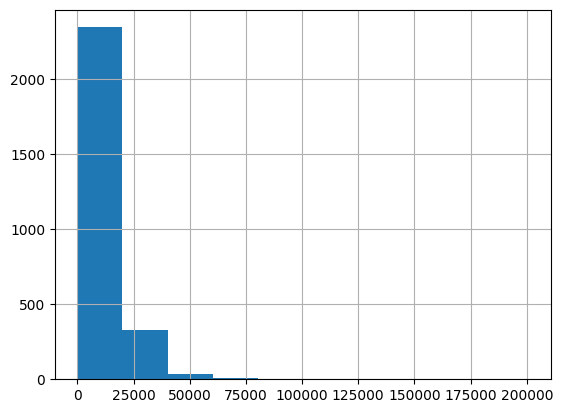

In [2076]:
df["Стоимость ремонта"].hist()

stat, p_value = stats.ks_2samp(df["Стоимость ремонта"], stats.chi2.rvs(df=len(df["Стоимость ремонта"])-1, size=len(df["Стоимость ремонта"])))
if p_value < 0.05:
    print("Распределение столбца 'Стоимость ремонта' не соответствует теоретическому распределению chi-square.")
else:
    print("Распределение столбца 'Стоимость ремонта' соответствует теоретическому распределению chi-square.")


stat, p_value = stats.ks_2samp(df["Стоимость ремонта"], stats.f.rvs(dfn=len(df["Стоимость ремонта"])-1, dfd=len(df["Стоимость ремонта"])-1, size=len(df["Стоимость ремонта"])))
if p_value < 0.05:
    print("Распределение столбца 'Стоимость ремонта' не соответствует теоретическому распределению Фишера.")
else:
    print("Распределение столбца 'Стоимость ремонта' соответствует теоретическому распределению Фишера.")


stat, p_value = stats.ks_2samp(df["Стоимость ремонта"], stats.expon.rvs(scale=1/df["Стоимость ремонта"].mean(), size=len(df["Стоимость ремонта"])))
if p_value < 0.05:
    print("Распределение столбца 'Стоимость ремонта' не соответствует теоретическому экспоненциальному распределению.")
else:
    print("Распределение столбца 'Стоимость ремонта' соответствует теоретическому экспоненциальному распределению.")


shape, loc, scale = stats.gamma.fit(df["Стоимость ремонта"])
stat, p_value = stats.ks_2samp(df["Стоимость ремонта"], stats.gamma.rvs(a=shape, loc=loc, scale=scale, size=len(df["Стоимость ремонта"])))
if p_value < 0.05:
    print("Распределение столбца 'Стоимость ремонта' не соответствует теоретическому гамма-распределению.")
else:
    print("Распределение столбца 'Стоимость ремонта' соответствует теоретическому гамма-распределению.")



Распределение столбца 'Пробег' не соответствует теоретическому распределению chi-square.
Распределение столбца 'Пробег' не соответствует теоретическому распределению Фишера.
Распределение столбца 'Пробег' не соответствует теоретическому экспоненциальному распределению.
Распределение столбца 'Пробег' не соответствует теоретическому гамма-распределению.


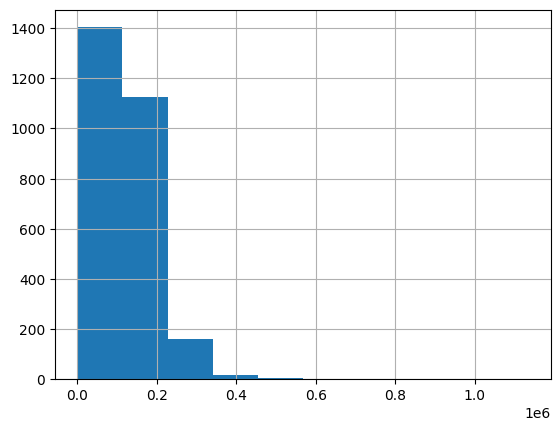

In [2077]:
df["Пробег"].hist()
mileage = df["Пробег"]

stat, p_value = stats.ks_2samp(mileage, stats.chi2.rvs(df=len(mileage)-1, size=len(mileage)))
if p_value < 0.05:
    print("Распределение столбца 'Пробег' не соответствует теоретическому распределению chi-square.")
else:
    print("Распределение столбца 'Пробег' соответствует теоретическому распределению chi-square.")

stat, p_value = stats.ks_2samp(mileage, stats.f.rvs(dfn=len(mileage)-1, dfd=len(mileage)-1, size=len(mileage)))
if p_value < 0.05:
    print("Распределение столбца 'Пробег' не соответствует теоретическому распределению Фишера.")
else:
    print("Распределение столбца 'Пробег' соответствует теоретическому распределению Фишера.")


stat, p_value = stats.ks_2samp(mileage, stats.expon.rvs(scale=1/mileage.mean(), size=len(mileage)))
if p_value < 0.05:
    print("Распределение столбца 'Пробег' не соответствует теоретическому экспоненциальному распределению.")
else:
    print("Распределение столбца 'Пробег' соответствует теоретическому экспоненциальному распределению.")


shape, loc, scale = stats.gamma.fit(mileage)
stat, p_value = stats.ks_2samp(mileage, stats.gamma.rvs(a=shape, loc=loc, scale=scale, size=len(mileage)))
if p_value < 0.05:
    print("Распределение столбца 'Пробег' не соответствует теоретическому гамма-распределению.")
else:
    print("Распределение столбца 'Пробег' соответствует теоретическому гамма-распределению.")


Распределение столбца 'Литры' не соответствует теоретическому распределению chi-square.
Распределение столбца 'Литры' не соответствует теоретическому распределению Фишера.
Распределение столбца 'Литры' не соответствует теоретическому экспоненциальному распределению.
Распределение столбца 'Литры' не соответствует теоретическому гамма-распределению.


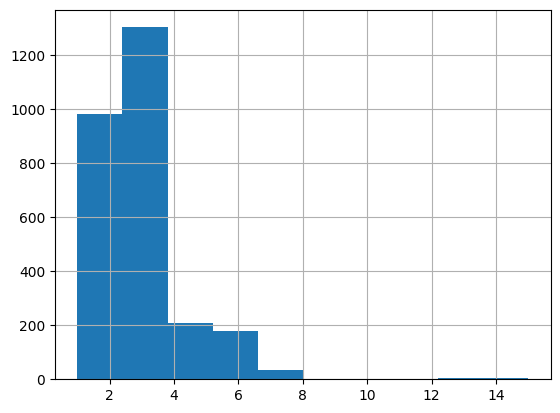

In [2078]:
df["Литры"].hist()

liters = df["Литры"]

stat, p_value = stats.ks_2samp(liters, stats.chi2.rvs(df=len(liters)-1, size=len(liters)))
if p_value < 0.05:
    print("Распределение столбца 'Литры' не соответствует теоретическому распределению chi-square.")
else:
    print("Распределение столбца 'Литры' соответствует теоретическому распределению chi-square.")


stat, p_value = stats.ks_2samp(liters, stats.f.rvs(dfn=len(liters)-1, dfd=len(liters)-1, size=len(liters)))
if p_value < 0.05:
    print("Распределение столбца 'Литры' не соответствует теоретическому распределению Фишера.")
else:
    print("Распределение столбца 'Литры' соответствует теоретическому распределению Фишера.")

stat, p_value = stats.ks_2samp(liters, stats.expon.rvs(scale=1/liters.mean(), size=len(liters)))
if p_value < 0.05:
    print("Распределение столбца 'Литры' не соответствует теоретическому экспоненциальному распределению.")
else:
    print("Распределение столбца 'Литры' соответствует теоретическому экспоненциальному распределению.")

shape, loc, scale = stats.gamma.fit(liters)
stat, p_value = stats.ks_2samp(liters, stats.gamma.rvs(a=shape, loc=loc, scale=scale, size=len(liters)))
if p_value < 0.05:
    print("Распределение столбца 'Литры' не соответствует теоретическому гамма-распределению.")
else:
    print("Распределение столбца 'Литры' соответствует теоретическому гамма-распределению.")


Распределение столбца 'Год' не соответствует теоретическому распределению chi-square.
Распределение столбца 'Год' не соответствует теоретическому распределению Фишера.
Распределение столбца 'Год' не соответствует теоретическому нормальному распределению.
Распределение столбца 'Год' не соответствует теоретическому равномерному распределению.


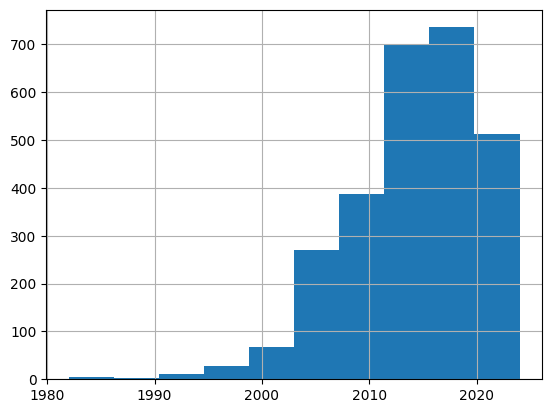

In [2079]:
df["Год"].hist()

year = df["Год"]

stat, p_value = stats.ks_2samp(year, stats.chi2.rvs(df=len(year)-1, size=len(year)))
if p_value < 0.05:
    print("Распределение столбца 'Год' не соответствует теоретическому распределению chi-square.")
else:
    print("Распределение столбца 'Год' соответствует теоретическому распределению chi-square.")

stat, p_value = stats.ks_2samp(year, stats.f.rvs(dfn=len(year)-1, dfd=len(year)-1, size=len(year)))
if p_value < 0.05:
    print("Распределение столбца 'Год' не соответствует теоретическому распределению Фишера.")
else:
    print("Распределение столбца 'Год' соответствует теоретическому распределению Фишера.")

stat, p_value = stats.ks_2samp(year, stats.norm.rvs(loc=year.mean(), scale=year.std(), size=len(year)))
if p_value < 0.05:
    print("Распределение столбца 'Год' не соответствует теоретическому нормальному распределению.")
else:
    print("Распределение столбца 'Год' соответствует теоретическому нормальному распределению.")


stat, p_value = stats.ks_2samp(year, stats.uniform.rvs(loc=year.min(), scale=year.max()-year.min(), size=len(year)))
if p_value < 0.05:
    print("Распределение столбца 'Год' не соответствует теоретическому равномерному распределению.")
else:
    print("Распределение столбца 'Год' соответствует теоретическому равномерному распределению.")


#### К сожалению, никакие гипотезы по поводу вида распределений не подтвердились

# Машинное обучение

In [2080]:
var_cat = np.array(['Марка', 'День недели', 'Период суток', 'Цвет', 'Коробка передач', 'Топливо', 'Привод', 'Техпаспорт', 'Тип повреждения', 'Основное повреждение', 
           'Второстепенное повреждение', 'Ключи', 'Кузов', 'Подтвержденность пробега', 'Цилиндры', 'Штат', 'Город', 'Чистка', 
          'Едет', 'Запуск двигателя', 'Записей о продаже'])

var_real = np.array(['Год', 'Литры', 'Пробег', 'Стоимость ремонта', 'Рыночная стоимость'])

var_cat_modified = np.array(['Марка', 'День недели', 'Период суток', 'Цвет', 'Коробка передач', 'Топливо', 'Привод', 'Техпаспорт', 'Тип повреждения', 'Основное повреждение', 
           'Второстепенное повреждение', 'Кузов', 'Подтвержденность пробега', 'Цилиндры', 'Штат', 'Город', 
          'Едет', 'Записей о продаже'])

var_real_modified = np.array(['Год', 'Литры', 'Пробег', 'Стоимость ремонта', 'Рыночная стоимость'])

df.columns

Index(['Выигрышная ставка', 'Записей о продаже', 'Пробег', 'Кузов', 'Цвет',
       'Топливо', 'Привод', 'Ключи', 'Стоимость ремонта', 'Рыночная стоимость',
       'Техпаспорт', 'Тип повреждения', 'Основное повреждение',
       'Второстепенное повреждение', 'Коробка передач', 'Город', 'Штат',
       'Подтвержденность пробега', 'Цилиндры', 'Литры', 'Год', 'Марка',
       'Чистка', 'Едет', 'Запуск двигателя', 'День недели', 'Период суток',
       'Логарифм таргета', 'Лог выигрышной ставки'],
      dtype='object')

In [2081]:
# Делаем понижение размерности, чтобы убрать сильно коррелируемые с другими признаки. Однако продолжим работу с 2 таблицами одновременно. Также будем работать с логарифмом выигрышной ставки
df=df.drop(["Выигрышная ставка",'Логарифм таргета'], axis=1)
df_modified=df.drop(['Чистка', 'Запуск двигателя', "Ключи"], axis=1)
X = df.drop("Лог выигрышной ставки", axis=1)
y = df["Лог выигрышной ставки"]
X_modified = df_modified.drop("Лог выигрышной ставки", axis=1)
y_modified = df_modified["Лог выигрышной ставки"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = pd.get_dummies(X_train, columns=var_cat).astype(float)
X_test = pd.get_dummies(X_test, columns=var_cat).astype(float)
X_train_modified = pd.get_dummies(X_train_modified, columns=var_cat_modified).astype(float)
X_test_modified = pd.get_dummies(X_test_modified, columns=var_cat_modified).astype(float)
# Убедимся, что у нас одинаковые столбцы в train и test наборах
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
X_train_modified, X_test_modified = X_train_modified.align(X_test_modified, join='left', axis=1, fill_value=0)

scaler = StandardScaler()
X_train[var_real] = scaler.fit_transform(X_train[var_real])
X_test[var_real] = scaler.transform(X_test[var_real])
X_train_modified[var_real_modified] = scaler.fit_transform(X_train_modified[var_real_modified])
X_test_modified[var_real_modified] = scaler.transform(X_test_modified[var_real_modified])

X_train.head()


,Пробег,Стоимость ремонта,Рыночная стоимость,Литры,Год,Марка_Acura,Марка_Audi,Марка_Bmw,Марка_Buick,Марка_Cadillac,...,Записей о продаже_6,Записей о продаже_7,Записей о продаже_8,Записей о продаже_9,Записей о продаже_10,Записей о продаже_12,Записей о продаже_16,Записей о продаже_17,Записей о продаже_21,Записей о продаже_60
VIN,,,,,,,,,,,,,,,,,,,,,
WDAPF4CC1E9565115,-1.259240,-1.051668,0.857507,0.045903,-0.012440,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1GNFC130X8J115060,2.062500,0.105015,-0.418539,1.712366,-1.005172,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G1BE5SM1HS573722,-0.093144,-1.051668,-0.263363,-1.113375,0.483926,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5TETU22N76Z236448,0.111022,-1.051668,-0.288527,0.770452,-1.336082,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1HGCY1F39PA007645,-1.277607,1.286844,1.336622,-1.040920,1.476659,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Обучать с помощью knn не будем, так как у нас очень много данных и признаков, а следовательно процесс обучения будет сложным по памяти. Попробуем построить линейную регрессию

In [2082]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')


model.fit(X_train_modified, y_train_modified)
y_train_pred = model.predict(X_train_modified)
y_test_pred = model.predict(X_test_modified)

mse_train =round(mean_squared_error(y_train_modified, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test_modified, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

coef_df = pd.DataFrame(model.coef_.flatten(), model.feature_names_in_, columns=['Coefficient'])
sorted_coef = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
print(sorted_coef)



Train MSE: 0.288
Test MSE: 1.5526204639867365e+20
Train MSE: 0.288
Test MSE: 4.018432694237162e+19
                             Coefficient
Привод_Front-wheel Drive   -3.189151e+11
Привод_4x4 w/front Whl Drv -3.189151e+11
Привод_All Wheel Drive     -3.189151e+11
Привод_Rear-wheel Drive    -3.189151e+11
Привод_4x4 w/rear Whl Drv  -3.189151e+11
...                                  ...
Чистка                      1.824735e-01
Рыночная стоимость          1.593729e-01
Литры                       1.382991e-01
Ключи                      -6.009341e-02
Стоимость ремонта           2.773964e-02

[539 rows x 1 columns]


In [2083]:
# Применим Лассо-регуляризацию, чтобы занулить не важные признаки и уменьшить переобучения
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1]}
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_lambda = grid_search.best_params_['alpha']
print(f'Оптимальное значение лямбды: {best_lambda}')

lasso_model = Lasso(alpha=best_lambda)
lasso_model.fit(X_train, y_train)
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

coef_df = pd.DataFrame(lasso_model.coef_, X_train.columns, columns=['Coefficient'])
non_zero_coef = coef_df[coef_df['Coefficient'] != 0]
print(non_zero_coef)

lasso_model.fit(X_train_modified, y_train_modified)
y_train_pred = lasso_model.predict(X_train_modified)
y_test_pred = lasso_model.predict(X_test_modified)

mse_train = round(mean_squared_error(y_train_modified, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test_modified, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

#переобучение уменьшилось!

Оптимальное значение лямбды: 0.001
Train MSE: 0.346
Test MSE: 0.628
                      Coefficient
Пробег              -2.657936e-01
Стоимость ремонта    2.049918e-02
Рыночная стоимость   1.782766e-01
Литры                1.299370e-01
Год                  6.528476e-01
...                           ...
Запуск двигателя_1   2.337492e-16
Записей о продаже_1  4.034613e-02
Записей о продаже_2 -1.285869e-01
Записей о продаже_3 -1.467824e-01
Записей о продаже_5 -3.975880e-01

[167 rows x 1 columns]
Train MSE: 0.346
Test MSE: 0.628


In [2084]:
# Попробуем применить регрессию с функцией потерь, основанной на Хубер-лосс. Таким образом, модель будет меньше штрафовать за выбросы
huber_regressor = HuberRegressor()
huber_regressor.fit(X_train, y_train)

y_train_pred = huber_regressor.predict(X_train)
y_test_pred = huber_regressor.predict(X_test)

mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
# В целом работает хорошо, но все-таки лассо-регрессия дает результат немного лучше

Train MSE: 0.321
Test MSE: 0.707


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [2085]:
# еще было бы хорошо создать доролнительные признаки, равные пермножению обычных и на них сделать лассо-регресиию, но я не помню, как это делать и как обрабатывать признаки. поэтому если ты можешь сделать, то
# было бы круто 

### Теперь попробуем обучить модель с помощью RandomForestRegressor и бустинга

In [2086]:
param_grid = {
    'n_estimators': [50],
    'max_depth': [10, 15, 17],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Optimal hyperparameters: {best_params}')


rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 min_samples_split=best_params['min_samples_split'],
                                 min_samples_leaf=best_params['min_samples_leaf'],
                                 random_state=42, bootstrap=True, oob_score=True )
rf_model.fit(X_train, y_train)


y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
print(feature_importances)

# Модель на тесте примерно такая же, как и Лассо-регрессия, но она намного сложнее, поэтому лучще будем ориентироваться на Лассо


Optimal hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Train MSE: 0.074
Test MSE: 0.666
                                           Feature  Importance
2                               Рыночная стоимость    0.515237
4                                              Год    0.208851
0                                           Пробег    0.038588
1                                Стоимость ремонта    0.019133
523                                         Едет_0    0.013266
..                                             ...         ...
434                                   Город_EXETER    0.000000
219  Техпаспорт_VT - CERT OF TITLE-SALVAGE VEHICLE    0.000000
223       Техпаспорт_WI - CERT OF TITLE-CLAIM PAID    0.000000
441                           Город_FREDERICKSBURG    0.000000
487                                    Город_OCALA    0.000000

[542 rows x 2 columns]


In [2087]:
param_grid = {
    'n_estimators': [50, 60, 65],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.3, 0.4]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Optimal hyperparameters: {best_params}')
gbr_model = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],
                                     max_depth=best_params['max_depth'],
                                     learning_rate=best_params['learning_rate'],
                                     random_state=42)
gbr_model.fit(X_train, y_train)

y_train_pred = gbr_model.predict(X_train)
y_test_pred = gbr_model.predict(X_test)

mse_train = round(mean_squared_error(y_train, y_train_pred), 3)
mse_test = round(mean_squared_error(y_test, y_test_pred), 3)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbr_model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
print(feature_importances)

# Удалось улучшить модель относительно Лассо и наглядно увидеть, какие признаки важнее для предсказания 

Optimal hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 65}
Train MSE: 0.175
Test MSE: 0.615
                                           Feature  Importance
2                               Рыночная стоимость    0.536007
4                                              Год    0.198854
0                                           Пробег    0.063158
524                                         Едет_1    0.020399
81                        Привод_Front-wheel Drive    0.018535
..                                             ...         ...
220                   Техпаспорт_WA - BILL OF SALE    0.000000
219  Техпаспорт_VT - CERT OF TITLE-SALVAGE VEHICLE    0.000000
218        Техпаспорт_VA - DEALER ONLY CLEAN TITLE    0.000000
217    Техпаспорт_VA - CERT OF TITLE-SALVAGE WATER    0.000000
541                           Записей о продаже_60    0.000000

[542 rows x 2 columns]
